# **Run Models Colab**

# Our 6 Models include Random Forests and XGBoost

Choose models to run at https://model.earth/realitystream/models  
Documentation https://model.earth/realitystream  
Backup resides in the: [RealityStream models folder](https://github.com/ModelEarth/realitystream/tree/main/models)  
Notes on running locally and in the cloud reside in our [cloud repo](https://github.com/modelearth/cloud/).

TO DO: Add files to a "report" folder. We send it's content to GitHub in the last step.

TO DO: For a unified html report, as each model completes, update a dataset with the performance accuracy scores and other metrics for all the models, then send to a report.md file. Save in the left 'report' folder which we push to Github in last step.

TO DO: Include the time it took to run each model in report.md.

DONE: Generate features-importance reports for available models. - Bin(Melody)

DONE: Performance metrics—including accuracy, ROC-AUC, G-Mean, best threshold, and classification reports—were aggregated into a modelResults dictionary using abbreviated keys. Top 10 feature importances for applicable models were included, and results were formatted into summary tables. - Yogesh Gajula

DONE: Function to calculate and append Correlation values to Unified Aggregation Results and Visual chart with prefix's for the top 10 Feature importances. - Yogesh Gajula

TO DO: Fix the error: name 'save_dir' is not defined. - Is this still occuring?  
Occured previously for both rbf and xgboost. Maybe others.

DONE Aashish: Used Pandas for integrated_df (became df) when save_training = False.  
DONE Loren: Loaded parameters.yaml and saved locally for customization.  
https://chatgpt.com/share/e4a2ee73-ab74-4551-9868-37b9b5b6b359  
DONE Tarun: Allow save-training to be set in the parameters.yaml values. Default to false. Use dash instead of underscore in yaml.

TO DO: Test that default target path for bee data works by deleting in left panel after pullin in parameters.yaml. Then test that panels 15 and 16 work.  
if param.targets.path: # Override with value from yaml  
    target_url = param.targets.path

target_df got problems.

TO DO: Pull 2-column target zip code UN topics directly from Google Data Commons based DCID target value in parameters.yaml

DONE Ivy: In the same panel as each accuracy report, call a new function called displayModelHeader to display the model name (as a bold header) and the file paths for features and targets above the report.

DONE Ivy: Show the parameter values below each path at the top of each accuracy report. So under the Feature path we'd have:  
startyear: 2017, endyear: 2021, naics: [6], state: ME

DONE Lily: Add support for multiple states. After running the third panel, you can edit the custom yaml on the right to set state: CT, ME, MA, NH, RI, VT.  Then add a loop that runs when there are multiple states. We'll add a file called parameters-new-england.yaml in the root of the RealityStream repo with the six states as features.states. Load here and add python to loop through the states.

TO DO: Add more parameters.yaml files that pull features/targets and join on the county Fips column. Add a path parameter that pulls from "all-years" which are generated by our [Industry Features CoLab](https://colab.research.google.com/drive/1HJnuilyEFjBpZLrgxDa4S0diekwMeqnh?usp=sharing). All years on GitHub:  
https://github.com/ModelEarth/community-timelines/tree/main/training/all-years
(These were created by Ronan)

DONE: Load blinks/parameters-blinks.yaml and use target.column to limit to y column

SAVE FOR LATER: Dropdown in webpage to send parameters.yaml 1 of these 4 bee targets (years).  
https://github.com/ModelEarth/bee-data/tree/main/targets

Done: Avoid sorting incoming parameters.yaml alphabetically. Attempt using  OrderedDict is commented out is several places below. Comment out prior alphabetical technique - we can provide a bool to toggle to it if it provides better security when requests are submitted through webpages. - Soham

DONE: Only import models requested by parameters.yaml. Move "from sklearn" imports to step after parameters are edited in textbox. - Tarun

IN PROGRESS: Creating install for Flask application with Google Cloud Run cmds at [github.com/modelearth/cloud](https://github.com/modelearth/cloud)

DONE: Send the params loaded from the default path to the widget diplay. - Prathyusha

DONE: Create an object that holds the 5 sample parameters.yaml paths that are on the RealityStream main page. When choosing one, send the path and the yaml it points at to the textarea below the path select menu. - Prathyusha

DONE: Parameter files displayed in select menu. Instead pull the select options from parameter-paths.csv - Prathyusha

DONE: Deactivate the right-side display of the yaml values and have the editing occur in the widget textbox. - Melody

TODO: Find a way to delete the existing files in the colab environment which interfers with the code when we re-run

TODO: imblearn import for cuML

 ⚠️ Please change your runtime type to T4 GPU.

## Importing Libraries and Intital Set-up

In [1]:
### Important: First change your runtime time to: T4 GPU under: Runtime > Change runtime type

### Important: Click "Restart session" when it pops up. This is required for older version of numpy used with cuml for faster Nividia processing.

verbose = False # True if you want full install logs; False to minimize output.

import subprocess

def run_cmd(cmd):
    """
    Runs a shell command. If verbose, prints stdout and stderr (on failure).
    Otherwise prints a simple 'Finished: <action>' message.
    Automatically uses a shell for 'python -c' commands to preserve quoting.
    """
    # Decide how to invoke subprocess based on need for shell (for python -c)
    if cmd.startswith("python -c"):
        result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    else:
        parts = cmd.split()
        result = subprocess.run(parts, capture_output=True, text=True)

    # Determine label for clean output
    if cmd.startswith("pip uninstall"):
        label = "uninstall"
    elif cmd.startswith("pip install"):
        label = "install"
    elif "import numpy" in cmd:
        label = "NumPy version check"
    elif "import cuml" in cmd:
        label = "cuML import check"
    else:
        parts = cmd.split()
        label = parts[1] if len(parts) > 1 else cmd

    if verbose:
        # verbose: show full output
        print(result.stdout)
        if result.returncode != 0:
            print(result.stderr)
    else:
        # clean: show only action label
        print(f"Finished: {label}")

# Uninstall conflicting or incompatible libraries
run_cmd(
    "pip uninstall -y jax jaxlib tensorflow treescope pymc thinc flax optax chex "
    "orbax-checkpoint dopamine-rl tensorflow-decision-forests tables spacy mlxtend fastai blosc2"
)

# Reinstall exact versions compatible with RAPIDS 25.2
run_cmd(
    "pip install numpy==1.24.4 scikit-learn==1.2.2 imbalanced-learn==0.11.0 --force-reinstall"
)

# Install RAPIDS 25.2 packages — all GPU-accelerated and version-pinned for compatibility
run_cmd(
    "pip install --extra-index-url=https://pypi.nvidia.com "
    "cudf-cu12==25.2.* cuml-cu12==25.2.* dask-cudf-cu12==25.2.* dask-cuda==25.2.* "
    "rapids-dask-dependency==25.2.* raft-dask-cu12==25.2.* "
    "rmm-cu12==25.2.* librmm-cu12==25.2.* pylibcudf-cu12==25.2.* "
    "libraft-cu12==25.2.* pylibraft-cu12==25.2.* libcuvs-cu12==25.2.* "
    "cuvs-cu12==25.2.* ucx-py-cu12==0.42.* ucxx-cu12==0.42.* distributed-ucxx-cu12==0.42.*"
)

# Confirm installations
run_cmd(
    'python -c "import numpy; print(\'NumPy version:\', numpy.__version__)"'
)
run_cmd(
    'python -c "import cuml; print(\'cuML imported successfully\')"'
)
print("Please restart the session for the changes to apply.")
print('Choose "Runtime > Restart Session" or when prompted to. The button we display 2 steps later probably doesn\'t work. Try fixing it.')


from google.colab import runtime
from IPython.display import display, HTML, Javascript

# Create a button with JavaScript that directly uses Colab's runtime API
# restart_button = HTML('''
# <button id="restartButton" style="background-color:#4CAF50; color:white; padding:8px 16px; border:none; border-radius:4px; cursor:pointer;">
#   Restart Session
# </button>
# <div id="statusMessage" style="margin-top:8px;"></div>

# <script>
# document.getElementById('restartButton').onclick = function() {
#   // Display restart message
#   // document.getElementById('statusMessage').innerHTML = '<div style="color:#4CAF50;">Attempting to restart session.</div>';

#   // Use Google Colab's runtime API to restart
#   try {
#     google.colab.kernel.invokeFunction('restart_colab', [], {});
#   } catch (error) {
#     document.getElementById('statusMessage').innerHTML = '<div style="color:#FF5733;">Error: ' + error.message + '</div>';
#   }
# };
# </script>
# ''')

# Function that will be called by the button
def restart_colab():
  display(HTML('<div style="color:#4CAF50;">Running runtime.restart_runtime()</div>'))
  # This is the most reliable way to restart Colab
  runtime.restart_runtime()

# Register the callback function
from google.colab import output
output.register_callback('restart_colab', restart_colab)

# Display the button
#display(restart_button)

# The rest in this step is a version of the above prepared by Claude AI. We can delete this if it's not helpful.
# First, check CUDA version available in Colab
#!nvidia-smi

# Uninstall conflicting packages more selectively
#!pip uninstall -y tensorflow tensorflow-decision-forests thinc spacy flax optax jax jaxlib

# Install compatible NumPy and scikit-learn versions first
#!pip install numpy==1.24.4 scikit-learn==1.2.2 --force-reinstall

# Install RAPIDS with proper error handling and fewer dependencies at once
#!pip install -q --extra-index-url=https://pypi.nvidia.com cudf-cu12==25.2.* cuml-cu12==25.2.* rmm-cu12==25.2.*

# Check if installation was successful
#!python -c "import cuml; print('cuML version:', cuml.__version__)"


Finished: uninstall
Finished: install
Finished: install
Finished: NumPy version check
Finished: cuML import check
Please restart the session for the changes to apply.
Choose "Runtime > Restart Session" or when prompted to. The button we display 2 steps later probably doesn't work. Try fixing it.


In [2]:
!pip install numpy==1.24.1 # Required for import cudf
#!pip install numpy==1.24.4 # Not working with import cudf yet.

# The "Restart Session" button may not work yet. Click the one in the popup instead.

# Click "Restart Session" when it pops up.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 52.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.8 requires numpy>=1.24.4, but you have numpy 1.24.1 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.24.1 which is incompatible.
xarray-einstats 0.9.0 requires numpy>=1.25, but you have numpy 1.24.1 which is incompatible.


In [1]:
save_training = False

# Required libraries
import cudf
import cuml
import cupy as cp
import numpy as np
import pandas as pd
import sklearn
import os
import regex as re
import logging
import pickle
import csv
import requests
import yaml
import ipywidgets as widgets
import pprint
import seaborn as sns
import matplotlib.pyplot as plt
import base64
import json
import re
from pathlib import Path
import time # Tarun 6/2/25

from google.colab import _message
from datetime import datetime
from google.colab import files
from io import StringIO
from collections import OrderedDict
from IPython.display import display, clear_output

print(" All imports successful. GPU ready for cuML and cuDF!")

 All imports successful. GPU ready for cuML and cuDF!


In [2]:
# GPU-Optimized Model Imports
from cuml.ensemble import RandomForestClassifier
from cuml.linear_model import LogisticRegression
from cuml.svm import SVC
from sklearn.neural_network import MLPClassifier   # MLP remains CPU-based
from xgboost import XGBClassifier                   # Will set GPU parameters during model creation
from imblearn.over_sampling import SMOTE            # SMOTE stays on CPU
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from xgboost import plot_importance

print(" Runtime environment is ready.")

 Runtime environment is ready.


In [3]:
REPORT_FOLDER = "report"  # Default path to the report folder in colab left-nav.

def setup_report_folder(report_folder=REPORT_FOLDER):
    """
    Create the report folder if it doesn't exist and download the report.html template and save as index.html.
    Returns the number of files in the folder.
    """
    # Create the report folder if it doesn't exist
    if not os.path.exists(report_folder):
        os.makedirs(report_folder)
        print(f"Created new directory: {report_folder}")

    # Check if index.html exists, if not download it
    index_file_path = os.path.join(report_folder, "index.html")
    if not os.path.exists(index_file_path):
        template_url = "https://raw.githubusercontent.com/ModelEarth/localsite/refs/heads/main/start/template/report.html"
        try:
            response = requests.get(template_url)
            response.raise_for_status()  # Raise an exception for HTTP errors

            with open(index_file_path, "w", encoding="utf-8") as f:
                f.write(response.text)
            print(f"Downloaded index.html template to {index_file_path}")
        except Exception as e:
            print(f"Error downloading template: {e}")

    add_readme_to_report_folder(report_folder)

def add_readme_to_report_folder(report_folder=REPORT_FOLDER):
    """
    Create a README.md file in the report folder if it doesn't exist yet.
    """
    readme_path = os.path.join(report_folder, "README.md")

    if not os.path.exists(readme_path):
        readme_content = "# Run Models Report\n\nThis folder contains generated reports from model executions."

        with open(readme_path, "w", encoding="utf-8") as f:
            f.write(readme_content)
        print(f"Created README.md in {report_folder}")

    return readme_path

setup_report_folder(REPORT_FOLDER)

Created new directory: report
Downloaded index.html template to report/index.html
Created README.md in report


In [4]:
markdown_lines = []


# Parameter Loader and Editor UI

This section builds an interactive user interface (UI) for loading, editing, and comparing YAML-based parameter files.

**Main functionalities:**
- Load available parameter sets from a remote CSV file (name → link).
- Display the URL and YAML contents of the selected parameter set.
- Allow users to edit YAML content directly in a text box.
- Detect and display:
  - Changes in the selected parameter source URL.
  - Differences between the previous and current remote YAML defaults.
  - Changes made to the YAML content in the text box.
- Safely update and store the current parameter state for further usage.
- Handle special cases like converting a single model string into a list.
- Expose key values like `param` (object-based access) and `save_training` (boolean flag) for downstream workflows.

In [5]:
#@title 🔧 Parameter Widget Setup { display-mode: "code" }

models = ['LR','RFC', 'RBF', 'SVM', 'MLP', 'XGBoost']

with open(os.path.join(REPORT_FOLDER, "model-options.csv"), 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  writer.writerow(['model_name'])
  for model in models:
    writer.writerow([model])

# ----------- Functions -------------
def load_parameter_paths_csv(url):
    """
    Download a CSV file from the given URL, read its contents, and return
    a dictionary where each entry maps the first column (name)
    to the second column (link).
    """
    resp = requests.get(url)
    resp.raise_for_status()
    reader = csv.reader(StringIO(resp.text))
    return {name: link for name, link in reader if len((name, link)) == 2}

def compute_diffs(dict_a, dict_b):
    """
    Compare two dictionaries and return a list of differences.
    Each difference is a tuple: (key, old_value, new_value).
    """
    diffs = []
    for key in sorted(set(dict_a) | set(dict_b)):
        old = dict_a.get(key)
        new = dict_b.get(key)
        if old != new:
            diffs.append((key, old, new))
    return diffs

def pretty_print_diff(title, diffs):
    """
    Nicely format and print differences with separate old/new fields.
    """
    if not diffs:
        return
    print(f"\n=== {title} ===")
    for key, old, new in diffs:
        print(f"• {key}:")
        print(f"    Old: {pprint.pformat(old, indent=8)}")
        print(f"    New: {pprint.pformat(new, indent=8)}\n")

class DictToObject:
    """
    Helper class that recursively converts a dictionary into an object
    with attributes, allowing access with dot notation.
    """
    def __init__(self, d):
        for k, v in d.items():
            if isinstance(v, dict):
                v = DictToObject(v)
            setattr(self, k, v)
    def __getattr__(self, name):
        return None

# --- Load Parameter Paths & Default Values ---

parameter_csv_url = (
    'https://raw.githubusercontent.com/ModelEarth/RealityStream/main/parameters/parameter-paths.csv'
)
parameter_paths = load_parameter_paths_csv(parameter_csv_url)

# Pick the first entry as the default
default_name = next(iter(parameter_paths))
default_url  = parameter_paths[default_name]

# Load Model Names from CSV
model_names = []
with open(os.path.join(REPORT_FOLDER, "model-options.csv"), 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        model_names.append(row['model_name'])

# --- Load and process the default YAML content ---
default_yaml_text = requests.get(default_url).text
default_yaml_dict = yaml.safe_load(default_yaml_text) or {}

# Extract and process default models
default_models = default_yaml_dict.get('models', [])
if isinstance(default_models, str):
    default_models = [default_models]
default_models_lower = [model.lower() for model in default_models]

# Remove 'models' key from the YAML dictionary
default_yaml_dict.pop('models', None)

# Convert the modified dictionary back to a YAML string
processed_yaml_text = yaml.safe_dump(default_yaml_dict, sort_keys=False)

# --- Widget Definitions ---

# Dropdown to select which parameter set to load
chooseParams_widget = widgets.Dropdown(
    options=list(parameter_paths.keys()),
    value=default_name,
    description='Params Path'
)

# Text field showing the URL of the selected YAML file
parametersSource_widget = widgets.Text(
    value=default_url,
    description='Params From',
    layout=widgets.Layout(width='1200px')
)

# Text area allowing inline editing of the YAML content
params_widget = widgets.Textarea(
    value=processed_yaml_text,
    description='Params',
    layout=widgets.Layout(width='1200px', height='200px')
)

# Button to trigger loading and diffing
apply_button = widgets.Button(
    description='Update',
    button_style='primary'
)

# Output area to display diffs and status
output = widgets.Output()

# --- Global State: Last URL and Parameter Content ---

# Track the last-used URL and parsed dictionaries,
# so we can diff against them on each Update click
last_url         = default_url
last_remote_dict = yaml.safe_load(requests.get(default_url).text) or {}
last_params_text = processed_yaml_text
last_edited_dict = default_yaml_dict
default_models = last_remote_dict.get('models', [])
if isinstance(default_models, str):
    default_models = [default_models]
default_models_lower = [model.lower() for model in default_models]

# Flag to track if the user has edited the params_widget
user_edited = False

# --- Create Model Checkboxes ---

model_checkboxes = []
for name in model_names:
    checked = name.lower() in default_models_lower
    cb = widgets.Checkbox(value=checked, description=name)
    model_checkboxes.append(cb)

model_selection_box = widgets.VBox(model_checkboxes)

# --- Event Callbacks ---

def on_path_change(change):
    """
    When the dropdown selection changes, update the URL field
    and load the new YAML into the editable text area.
    """
    if change['name'] == 'value' and change['type'] == 'change':
        name = change['new']
        url  = parameter_paths[name]
        parametersSource_widget.value = url
        yaml_text = requests.get(url).text
        yaml_dict = yaml.safe_load(yaml_text) or {}

        # Update default models
        global default_models
        default_models = yaml_dict.get('models', [])
        if isinstance(default_models, str):
            default_models = [default_models]
        default_models_lower = [model.lower() for model in default_models]

        # Update checkboxes
        for cb in model_checkboxes:
            cb.value = cb.description.lower() in default_models_lower

        # Remove 'models' key from the YAML dictionary
        yaml_dict.pop('models', None)

        # Update the text area with the modified YAML
        params_widget.value = yaml.safe_dump(yaml_dict, sort_keys=False)

        # Reset the user_edited flag
        global user_edited
        user_edited = False

chooseParams_widget.observe(on_path_change)

def on_params_change(change):
    """
    Set the user_edited flag to True when the user edits the params_widget.
    """
    global user_edited
    user_edited = True

params_widget.observe(on_params_change, names='value')

def on_update_clicked(_):
    """
    Each time the Update button is clicked:
    1. Compare the edited YAML text to the last edit and print any key/value changes.
    2. Compare the current URL to the last URL and print any change.
    3. Diff the remote defaults for both old & new URLs.
    4. Update the 'last_' state variables for the next click.
    """
    global last_url, last_remote_dict, last_params_text, last_edited_dict, param, save_training, default_models, user_edited

    with output:
        clear_output()

        # Capture current values first
        current_url = parametersSource_widget.value
        current_text = params_widget.value
        print("\n")  # Space before text

        # 1) YAML content edit detection FIRST
        if user_edited:
            try:
                current_edit = yaml.safe_load(current_text) or {}
            except yaml.YAMLError as e:
                print(f"Error parsing edited YAML: {e}")
                return
            content_diffs = compute_diffs(last_edited_dict, current_edit)
            if content_diffs:
                pretty_print_diff("YAML edits since last update", content_diffs)
            else:
                print("YAML text changed but no key/value differences.\n")
            last_params_text = current_text
            last_edited_dict = current_edit
            user_edited = False
        else:
            print("YAML content unchanged since last update.\n")

        # 2) URL change detection
        if current_url != last_url:
            print(f"\n=== URL changed ===\n")
            print(f"  {last_url!r} → {current_url!r}\n")
            try:
                new_remote = yaml.safe_load(requests.get(current_url).text) or {}
            except Exception as e:
                print(f"Error fetching new remote parameters: {e}")
                return
            path_diffs = compute_diffs(last_remote_dict, new_remote)
            if path_diffs:
                pretty_print_diff("Default parameters changed between URLs", path_diffs)
            else:
                print("No default-parameter differences between those URLs.\n")
            last_url = current_url
            last_remote_dict = new_remote
        else:
            print(f"URL unchanged: {current_url!r}\n")

        # 3) Update models from checkboxes
        selected_models = [cb.description for cb in model_checkboxes if cb.value]
        if selected_models:
            last_edited_dict['models'] = selected_models
            print(f"Selected models: {selected_models}")
        else:
            print("No models selected.")

        # Compare selected models with default models (case-insensitive)
        selected_models_lower = [model.lower() for model in selected_models]
        default_models_lower = [model.lower() for model in default_models]

        added_models = [model for model in selected_models if model.lower() not in default_models_lower]
        removed_models = [model for model in default_models if model.lower() not in selected_models_lower]

        if added_models or removed_models:
            print("\n=== Model Selection Changes ===")
            if added_models:
                print(f"Added models: {added_models}")
            if removed_models:
                print(f"Removed models: {removed_models}")
        else:
            print("Model selection unchanged.")

        # Update default_models for next comparison
        default_models = selected_models.copy()

        # 4) Build updated param and save_training
        param = DictToObject(OrderedDict(last_edited_dict))
        save_training = getattr(param, 'save_training', False)

        save_pickle = getattr(param, 'save_pickle', False)  # Tarun
        print(f"save_pickle set to: {save_pickle}")  # Tarun

        # Changes tarun
        # Define mapping of model keys to full import

        import importlib

        model_import_paths = {
            "RFC": "sklearn.ensemble.RandomForestClassifier",
            "RBF": "sklearn.ensemble.RandomForestClassifier",  # alias
            "LR": "sklearn.linear_model.LogisticRegression",
            "LogisticRegression": "sklearn.linear_model.LogisticRegression",
            "SVM": "sklearn.svm.SVC",
            "MLP": "sklearn.neural_network.MLPClassifier",
            "XGBoost": "xgboost.XGBClassifier"
        }


        # Create a dictionary to store dynamically imported model classes
        loaded_model_classes = {}

        # Use param_dict for safe access
        requested_models = last_edited_dict.get("models", [])

        for model_name in requested_models:
            if model_name not in model_import_paths:
                print(f" Unknown model: {model_name}")
                continue

            full_path = model_import_paths[model_name]
            module_name, class_name = full_path.rsplit('.', 1)

            try:
                module = importlib.import_module(module_name)
                model_class = getattr(module, class_name)
                loaded_model_classes[model_name] = model_class
                print(f" Loaded {model_name} from {module_name}")
            except (ImportError, AttributeError) as e:
                print(f" Failed to import {model_name}: {e}")

        # 5) Fix single model case: always make models a list
        if isinstance(last_edited_dict.get("models"), str):
            last_edited_dict["models"] = [last_edited_dict["models"]]
            param = DictToObject(OrderedDict(last_edited_dict))  # Rebuild after fix

apply_button.on_click(on_update_clicked)

# --- Display the UI ---

ui = widgets.VBox([
    chooseParams_widget,
    parametersSource_widget,
    params_widget,
    model_selection_box,
    apply_button,
    output
])
display(ui)
on_update_clicked(None)

In [6]:
# Assuming 'param' is an instance of DictToObject from previous code blocks
# Define necessary adjustments to your setup

# Settings
model_name = "RandomForest"  # Specify the model to be trained
all_model_list = ["LogisticRegression", "SVM", "MLP", "RandomForest", "XGBoost"]  # All usable models
assert model_name in all_model_list, "Model not supported"
valid_report_list = ["RandomForest", "XGBoost"]  # Valid models for feature-importance report

random_state = 42  # Random state for reproducibility
# print(param.features.path)
#print(param.targets.__dict__)

# Tarun changes
# Dynamically import only the models specified in param.models
available_model_classes = {}

# Normalize all names to lowercase to match YAML inputs
requested_models = [m.lower() for m in last_edited_dict.get('models', [])]

if 'randomforest' in requested_models:
    from sklearn.ensemble import RandomForestClassifier
    available_model_classes['RandomForest'] = RandomForestClassifier

if 'svm' in requested_models:
    from sklearn.svm import SVC
    available_model_classes['SVM'] = SVC

if 'logisticregression' in requested_models:
    from sklearn.linear_model import LogisticRegression
    available_model_classes['LogisticRegression'] = LogisticRegression

if 'mlp' in requested_models:
    from sklearn.neural_network import MLPClassifier
    available_model_classes['MLP'] = MLPClassifier

if 'xgboost' in requested_models:
    import xgboost as xgb
    available_model_classes['XGBoost'] = xgb.XGBClassifier

print(param.targets.path)
# Access the 'path' key within the 'targets' object safely
target_url = param.targets.path
target_df = pd.read_csv(target_url)
print(target_df.head())

# Dynamically identify the location column
location_columns = ["Country", "State", "Fips", "Zip", "Voxel"]
location_column = next((col for col in target_df.columns if col in location_columns), None)
if not location_column:
    raise ValueError("No valid location column found in the target dataset.")
print(f"Location column identified: {location_column}")

# Dynamically identify the target column
# TO DO: Convert all incoming to lowercase to column name "target" also works.
target_column = "Target" if "Target" in target_df.columns else None
if not target_column:
    #raise ValueError("The 'Target' column is not found in the target dataset.")
    print("The 'Target' column is not found in the target dataset.")
print(f"Target column identified: {target_column}")

# Directory Information
dataset_name = "Name needs to be added"
merged_save_dir = f"../process/{dataset_name}/states-{target_column}-{dataset_name}"  # Directory for state-separate dataset
full_save_dir = f"../output/{dataset_name}/training"  # Directory for the integrated dataset


https://raw.githubusercontent.com/ModelEarth/bee-data/main/targets/bees-targets-top-20-percent.csv
   Fips  Target
0  1001       0
1  1011       0
2  1047       0
3  1051       0
4  1063       0
Location column identified: Fips
Target column identified: Target


In [7]:
# STEP: Create Functions
def rename_columns(df, year):
    rename_mapping = {}
    for column in df.columns:
      if column not in df.columns[:2]:
          new_column_name = column + f'-{year}'
          rename_mapping[column] = new_column_name
    df.rename(columns=rename_mapping, inplace=True)

def check_directory(directory_path): # Check whether the given directory exists, if not, then create it
    if not os.path.exists(directory_path):
        try:
            os.makedirs(directory_path)
            print(f"Directory '{directory_path}' created successfully by check_directory.")
        except OSError as e:
            print(f"Error creating directory '{directory_path}': {e}")
    else:
        print("Current working directory:", os.getcwd())
        print("View under the folder icon which is followed by 2 dots..")
        print(f"check_directory '{directory_path}' already exists.")
    return directory_path

# Model functions

In [8]:
import os
import pickle
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import time

# Display model header with parameters
def displayModelHeader(featurePath, targetPath, model):
    """
    Display the header for the model report.

    Args:
        featurePath (str): The path to the features.
        targetPath (str): The path to the targets.
        model (str): The name of the model.
    """
    print(f"\033[1mModel: {model}\033[0m")
    print(f"Feature path: {featurePath}")
    print(f"Target path: {targetPath}")
    print(f"startyear: {param.features.startyear}, endyear: {param.features.endyear}, naics: {param.features.naics}, state: {param.features.state}")

# Train the model and get the test report
def train_model(model, X_train, y_train, X_test, y_test, over_sample):
    """
    Train the model and evaluate its performance.

    Args:
        model: The machine learning model to train.
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training targets.
        X_test (pd.DataFrame): Testing features.
        y_test (pd.Series): Testing targets.
        over_sample (bool): Flag to indicate if oversampling should be applied.

    Returns:
        tuple: Contains model, predictions, accuracy number, G-mean, and classification report dictionary.
    """
    if over_sample:
        sm = SMOTE(random_state=2)
        X_train, y_train = sm.fit_resample(X_train, y_train.ravel())
        print("Oversampling done for training data.")

    start = time.time() # Tarun
    model.fit(X_train, y_train)
    print("Model fitted successfully.")

    # Calculate predictions and metrics
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)
    end = time.time() # Tarun
    duration = end - start # Tarun


    # ROC-AUC score
    roc_auc = round(roc_auc_score(y_test, y_pred_prob[:, 1]), 2)
    print(f"\033[1mROC-AUC Score\033[0m: {roc_auc * 100} %")

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1], pos_label=1)
    gmeans = np.sqrt(tpr * (1 - fpr))
    ix = np.argmax(gmeans)

    print('\033[1mBest Threshold\033[0m: %.3f \n\033[1mG-Mean\033[0m: %.3f' % (thresholds[ix], gmeans[ix]))
    best_threshold_num = round(thresholds[ix], 3)
    gmeans_num = round(gmeans[ix], 3)

    # Update predictions based on the best threshold
    y_pred = (y_pred > thresholds[ix])

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_num = f"{accuracy * 100:.1f}"

    print("\033[1mModel Accuracy\033[0m: ", round(accuracy, 2) * 100, "%")
    print("\033[1m\nClassification Report:\033[0m")

    # Generate classification report
    cfc_report = classification_report(y_test, y_pred)
    cfc_report_dict = classification_report(y_test, y_pred, output_dict=True)
    print(cfc_report)

    return model, y_pred, accuracy_num, gmeans_num, roc_auc, best_threshold_num, cfc_report_dict, duration # Added duration as return Tarun

# Train the specified model, impute NaN values, and save the trained model along with the feature-target report
def train(featurePath, targetPath, model_name, target_column, dataset_name, X_train, y_train, X_test, y_test, report_gen, all_model_list, valid_report_list, over_sample=False, model_saving=True,save_pickle=False, random_state=42):
    """
    Train the specified model and save it along with the reports.

    Args:
        featurePath (str): The path to the features.
        targetPath (str): The path to the targets.
        model_name (str): The name of the model to train.
        target_column (str): The target column name.
        dataset_name (str): The name of the dataset.
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training targets.
        X_test (pd.DataFrame): Testing features.
        y_test (pd.Series): Testing targets.
        report_gen (bool): Flag to indicate if a report should be generated.
        all_model_list (list): List of all available models.
        valid_report_list (list): List of models that support report generation.
        over_sample (bool): Flag to indicate if oversampling should be applied.
        model_saving (bool): Flag to indicate if the model should be saved.
        random_state (int): Random state for reproducibility.

    Returns:
        tuple: Contains paths and evaluation metrics.
    """
    assert model_name in all_model_list, f"Invalid model name: {model_name}. Must be one of {all_model_list}."

    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # model_mapping = {
    # "LogisticRegression": LogisticRegression(max_iter=10000),  # from cuml.linear_model
    # "SVM": SVC(probability=True),  # from cuml.svm
    # "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=1000, random_state=random_state),  # CPU model
    # "RandomForest": RandomForestClassifier(n_estimators=1000, criterion="gini", random_state=random_state),  # from cuml.ensemble
    # "XGBoost": xgb.XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor', random_state=random_state, enable_categorical=True)  # GPU-enabled XGB
    # }


    # model = model_mapping.get(model_name)
    # Tarun changes and commented above model mapping code.
    model_class = available_model_classes.get(model_name)

    if not model_class:
        raise ValueError(f"Model class for {model_name} not found in available_model_classes.")

    # Customize default parameters
    if model_name == "LogisticRegression":
        model = model_class(max_iter=10000)
    elif model_name == "SVM":
        model = model_class(probability=True)
    elif model_name == "MLP":
        model = model_class(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=1000, random_state=random_state)
    elif model_name == "RandomForest":
        model = model_class(n_estimators=1000, criterion="gini", random_state=random_state)
    elif model_name == "XGBoost":
        model = model_class(tree_method='gpu_hist', predictor='gpu_predictor', random_state=random_state, enable_categorical=True)
    else:
        model = model_class()

    model_fullname = model_name.replace("RandomForest", "Random Forest").replace("XGBoost", "XGBoost")

    displayModelHeader(featurePath, targetPath, model_fullname)

    if model_name == "XGBoost":
        model, y_pred, accuracy_num, gmeans_num, roc_auc, best_threshold_num, cfc_report_dict, runtime_seconds = train_model(model, X_train, y_train, X_test, y_test, over_sample)
    else:
        model, y_pred, accuracy_num, gmeans_num, roc_auc, best_threshold_num, cfc_report_dict, runtime_seconds = train_model(model, X_train_imputed, y_train, X_test_imputed, y_test, over_sample)

    save_dir = f"../output/{dataset_name}/saved"
    check_directory(save_dir)

    if model_saving and save_pickle:  # Tarun: Added save-pickle flag
        save_model(model, imputer if model_name != "XGBoost" else None, target_column, dataset_name, model_name, save_dir)

    if report_gen:
        if model_name in valid_report_list:
            if model_name == "RandomForest":
                importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_})
            elif model_name == "XGBoost":
                importance_df = pd.DataFrame(list(model.get_booster().get_score().items()), columns=["Feature", "Importance"])
            report = importance_df.sort_values(by='Importance', ascending=False)
            report["Feature_Name"] = report["Feature"].apply(report_modify)
            report = report.reindex(columns=["Feature", "Feature_Name", "Importance"])
            report.to_csv(os.path.join(save_dir, f"{target_column}-{dataset_name}-report-{model_name}.csv"), index=False)
        else:
            print("No valid report for the current model")

    return featurePath, targetPath, model, y_pred, report, model_fullname, cfc_report_dict, accuracy_num, gmeans_num, roc_auc, best_threshold_num

# Save the trained model and NaN-value imputer
def save_model(model, imputer, target_column, dataset_name, model_name, save_dir):
    """
    Save the trained model and imputer to disk.

    Args:
        model: The trained model to save.
        imputer: The imputer used for missing values, if applicable.
        target_column (str): The target column name.
        dataset_name (str): The name of the dataset.
        model_name (str): The name of the model.
        save_dir (str): The directory where the model will be saved.
    """
    data = {
        "model": model,
        "imputer": imputer
    }
    with open(os.path.join(save_dir, f"{target_column}-{dataset_name}-trained-{model_name}.pkl"), 'wb') as file:
        pickle.dump(data, file)

# Modify the feature-importance report by adding an industry-correspondence introduction column
def report_modify(value):
    """
    Modify feature names for better readability in reports.

    Args:
        value (str): The original feature name.

    Returns:
        str: The modified feature name.
    """
    splitted = value.split("-")
    if splitted[0] in ["Emp", "Est", "Pay"]:
        try:
            modified = splitted[0] + "-" + INDUSTRIES_DICT[splitted[1]] + "-" + splitted[2]
        except KeyError:
            modified = value  # Keep original if not found
        return modified
    else:
        return value


In [9]:
# STEP: Read the single CSV file and save it as the full dataset csv
# If save_training=True, your files will reside in the "output" folder.

save_dir = full_save_dir  # Use the local directory if save_training is True

# Check if the directory exists or create it
check_directory(save_dir)

# Since there is only one CSV file, directly read and process it
csv_file = f"../process/{dataset_name}/{target_column}-{dataset_name}.csv"

# Ensure csv_file is available before reading
if save_training:
    if os.path.exists(csv_file):  # Check if the CSV file exists
        df = pd.read_csv(csv_file)
        print(f"Read file from: {csv_file}")
        # Save the integrated file to the desired location
        file_path = os.path.join(save_dir, f"{target_column}-{dataset_name}.csv")
        df.to_csv(file_path, index=False)
        print(f"Saved file at: {file_path}")
    else:
        print(f"Warning: CSV file not found at {csv_file}. Please check the path.")


Directory '../output/Name needs to be added/training' created successfully by check_directory.


In [10]:
print(f"target_column: {target_column}")
print(f"dataset_name: {dataset_name}")

target_column: Target
dataset_name: Name needs to be added


In [11]:
file_path = os.path.join(full_save_dir, f"{target_column}-{dataset_name}.csv")
print(f"Reading file from: {file_path}")

Reading file from: ../output/Name needs to be added/training/Target-Name needs to be added.csv


In [12]:
target_df

,Fips,Target
0,1001,0
1,1011,0
2,1047,0
3,1051,0
4,1063,0
...,...,...
2742,56031,0
2743,56023,0
2744,56035,0
2745,56039,0


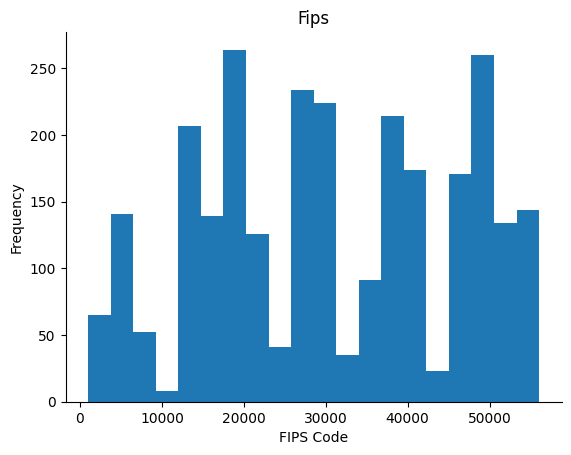

In [13]:
#TODO : Add details for the fips code; and maybe figure out why the fips from other states popup
import pandas as pd
from matplotlib import pyplot as plt

# Check if 'target_df' exists and has 'Fips' column
if 'target_df' in locals() and 'Fips' in target_df.columns:
    # Convert 'Fips' to numeric if it's not already
    target_df['Fips'] = pd.to_numeric(target_df['Fips'], errors='coerce')

    # Plot histogram
    target_df['Fips'].plot(kind='hist', bins=20, title='Fips')
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.xlabel('FIPS Code')  # Label for x-axis
    plt.ylabel('Frequency')    # Label for y-axis
    plt.show()  # Show the plot
else:
    print("Error: target_df is not defined or 'Fips' column is missing.")

In [14]:
# STEP: Get Dictionaries for states and industries

# TO DO: Try including DC and US Territories
STATE_DICT = {
    "AL": "Alabama", "AK": "Alaska", "AZ": "Arizona", "AR": "Arkansas", "CA": "California", "CO": "Colorado",
    "CT": "Connecticut", "DE": "Delaware", "FL": "Florida", "GA": "Georgia", "HI": "Hawaii", "ID": "Idaho",
    "IL": "Illinois", "IN": "Indiana", "IA": "Iowa", "KS": "Kansas", "KY": "Kentucky", "LA": "Louisiana",
    "ME": "Maine", "MD": "Maryland", "MA": "Massachusetts", "MI": "Michigan", "MN": "Minnesota", "MS": "Mississippi",
    "MO": "Missouri", "MT": "Montana", "NE": "Nebraska", "NV": "Nevada", "NH": "New Hampshire", "NJ": "New Jersey",
    "NM": "New Mexico", "NY": "New York", "NC": "North Carolina", "ND": "North Dakota", "OH": "Ohio", "OK": "Oklahoma",
    "OR": "Oregon", "PA": "Pennsylvania", "RI": "Rhode Island", "SC": "South Carolina", "SD": "South Dakota",
    "TN": "Tennessee", "TX": "Texas", "UT": "Utah", "VT": "Vermont", "VA": "Virginia", "WA": "Washington",
    "WV": "West Virginia", "WI": "Wisconsin", "WY": "Wyoming",
    "DC": "District of Columbia",
    # US Territories
    "AS": "American Samoa", "GU": "Guam", "MP": "Northern Mariana Islands", "PR": "Puerto Rico", "VI": "U.S. Virgin Islands"
}

STATE_DICT_DELETE = {
    "AL": "ALABAMA","AK": "ALASKA","AZ": "ARIZONA","AR": "ARKANSAS","CA": "CALIFORNIA","CO": "COLORADO","CT": "CONNECTICUT","DE": "DELAWARE","FL": "FLORIDA","GA": "GEORGIA","HI": "HAWAII","ID": "IDAHO","IL": "ILLINOIS","IN": "INDIANA","IA": "IOWA","KS": "KANSAS","KY": "KENTUCKY","LA": "LOUISIANA","ME": "MAINE","MD": "MARYLAND","MA": "MASSACHUSETTS","MI": "MICHIGAN","MN": "MINNESOTA","MS": "MISSISSIPPI","MO": "MISSOURI","MT": "MONTANA","NE": "NEBRASKA","NV": "NEVADA","NH": "NEW HAMPSHIRE","NJ": "NEW JERSEY","NM": "NEW MEXICO","NY": "NEW YORK","NC": "NORTH CAROLINA","ND": "NORTH DAKOTA","OH": "OHIO","OK": "OKLAHOMA","OR": "OREGON","PA": "PENNSYLVANIA","RI": "RHODE ISLAND","SC": "SOUTH CAROLINA","SD": "SOUTH DAKOTA","TN": "TENNESSEE","TX": "TEXAS","UT": "UTAH","VT": "VERMONT","VA": "VIRGINIA","WA": "WASHINGTON","WV": "WEST VIRGINIA","WI": "WISCONSIN","WY": "WYOMING"
}

In [15]:
# Define INDUSTRIES_DICT as an empty dictionary initially
# industries_df is not currently in use - File only exists for country US and naics 2.
# TO DO: Use to show top level industry categories in importance reports
# Source: https://github.com/ModelEarth/community-data/blob/master/us/id_lists/naics2.csv
INDUSTRIES_DICT = {}
country = "US"
naics_level = 2
industries_csv_file = f"https://raw.githubusercontent.com/ModelEarth/community-data/master/{country.lower()}/id_lists/naics{naics_level}.csv"
# Attempt to load the industries DataFrame from URL
try:
    industries_df = pd.read_csv(
        f"https://raw.githubusercontent.com/ModelEarth/community-data/master/{country.lower()}/id_lists/naics{naics_level}.csv",
        header=None
    )
    INDUSTRIES_DICT = industries_df.set_index(0).to_dict()[1]
    print("Successfully loaded industries_df from URL.")
except Exception as e:
    print(f"Failed to load industries_df from URL due to error: {e}")
    # Try loading from the local file path as a fallback
    try:
        industries_df = pd.read_csv(industries_csv_file, header=None, names=['Industry_Code', 'Industry_Name'])
        INDUSTRIES_DICT = industries_df.set_index('Industry_Code').to_dict()['Industry_Name']
        print("Successfully loaded industries_df from local file.")
    except FileNotFoundError:
        print(f"Error: The file {industries_csv_file} does not exist.")
    except pd.errors.EmptyDataError:
        print("Error: The CSV file is empty.")
    except pd.errors.ParserError:
        print("Error: There was a parsing error while reading the CSV file.")
    except Exception as e:
        print(f"An error occurred while loading the CSV: {e}")

# Now, print the columns of industries_df if it is defined
if 'industries_df' in locals():  # Check if industries_df is defined
    print("Columns in industries_df:")
    print(industries_df.columns)
else:
    print("Error: industries_df is not defined. Please check the loading process.")

Successfully loaded industries_df from URL.
Columns in industries_df:
Index([0, 1], dtype='int64')


In [16]:
target_df

,Fips,Target
0,1001,0
1,1011,0
2,1047,0
3,1051,0
4,1063,0
...,...,...
2742,56031,0
2743,56023,0
2744,56035,0
2745,56039,0


In [17]:
import os
import pandas as pd
import cudf
import cupy as cp
from sklearn.model_selection import train_test_split

# Parameters - TO DO: to be deleted
param = {
    "folder": "naics6-bees-counties",
    "features": {
        "data": "industries",
        "startyear": 2017,
        "endyear": 2021,
        "path": "https://raw.githubusercontent.com/ModelEarth/community-timelines/main/training/naics{naics}/US/counties/{year}/US-{state}-training-naics{naics}-counties-{year}.csv",
    },
    "targets": {
        "data": "bees",
        "path": "https://github.com/ModelEarth/bee-data/raw/main/targets/bees-targets-top-20-percent.csv",
    },
    "models": ["xgboost"],
}
# Was: "models": ["lr", "svc", "rfc", "rbf", "xgboost"]

# TO DO
# To be the default. All other params are from incoming yaml, then are edited in textbox inside this colab.
paramDefaults = {
    "folder": "myfolder",
    "models": ["xgboost"]
}
# Paths and settings
target_url = param["targets"]["path"]
features_template = param["features"]["path"]

# TO DO: Get from param instead - this value is optional
naics = 6

# TO DO: This value is optional
years = range(param["features"]["startyear"], param["features"]["endyear"] + 1)

# TO DO: Get states from param instead - this value is optional
states = ["ME", "NY"]

full_save_dir = "output/training"

os.makedirs(full_save_dir, exist_ok=True)

# Build feature file paths
feature_files = []
for state in states:
    for year in years:
        feature_files.append(features_template.format(naics=naics, year=year, state=state))

print("Constructed Feature File Paths:")
for feature_file in feature_files:
    print(feature_file)

# Load feature datasets
feature_dfs = []
for feature_file in feature_files:
    try:
        feature_dfs.append(pd.read_csv(feature_file))
        print(f"Loaded feature file: {feature_file}")
    except Exception as e:
        print(f"Error loading feature file {feature_file}: {e}")

if not feature_dfs:
    raise FileNotFoundError("No feature files could be loaded. Please check the paths and try again.")

features_df = pd.concat(feature_dfs, ignore_index=True)

# Load target dataset
try:
    target_df = pd.read_csv(target_url)
    print("Targets loaded successfully.")
except Exception as e:
    raise FileNotFoundError(f"Error loading target file {target_url}: {e}")

# Make Fips columns consistent
features_df["Fips"] = features_df["Fips"].astype(str)
target_df["Fips"] = target_df["Fips"].astype(str)

# Filter features_df to only Fips present in target_df
features_df = features_df[features_df["Fips"].isin(target_df["Fips"])]

# Sort and merge
features_df = features_df.sort_values(by="Fips")
target_df = target_df.sort_values(by="Fips")

aligned_df = pd.merge(features_df, target_df, on="Fips", how="inner")

# Verify merged data
print("\nMerged aligned_df shape:", aligned_df.shape)

# Separate features and target
X_total_cpu = aligned_df.drop(columns=["Target"])
y_total_cpu = aligned_df["Target"]

print("X_total_cpu shape:", X_total_cpu.shape)
print("y_total_cpu shape:", y_total_cpu.shape)

# Convert to GPU
X_total = cudf.DataFrame.from_pandas(X_total_cpu)
y_total = cp.asarray(y_total_cpu)

print("Data converted to GPU format successfully.")
print("X_total (GPU) rows:", len(X_total))
print("y_total (GPU) rows:", len(y_total))


Constructed Feature File Paths:
https://raw.githubusercontent.com/ModelEarth/community-timelines/main/training/naics6/US/counties/2017/US-ME-training-naics6-counties-2017.csv
https://raw.githubusercontent.com/ModelEarth/community-timelines/main/training/naics6/US/counties/2018/US-ME-training-naics6-counties-2018.csv
https://raw.githubusercontent.com/ModelEarth/community-timelines/main/training/naics6/US/counties/2019/US-ME-training-naics6-counties-2019.csv
https://raw.githubusercontent.com/ModelEarth/community-timelines/main/training/naics6/US/counties/2020/US-ME-training-naics6-counties-2020.csv
https://raw.githubusercontent.com/ModelEarth/community-timelines/main/training/naics6/US/counties/2021/US-ME-training-naics6-counties-2021.csv
https://raw.githubusercontent.com/ModelEarth/community-timelines/main/training/naics6/US/counties/2017/US-NY-training-naics6-counties-2017.csv
https://raw.githubusercontent.com/ModelEarth/community-timelines/main/training/naics6/US/counties/2018/US-NY-t

# EDA

In [18]:
def basic_info(df):
    print("\nData Overview")
    print(df.head())
    print("\nShape of the dataset:", df.shape)
    print("\nColumn Information:")
    print(df.info())
    print("\nDescriptive Statistics:")

    if isinstance(df, cudf.DataFrame):
        print(df.describe())  # no transpose for cudf
    else:
        print(df.describe().T)  # transpose for pandas

    print("\nNull Values:")
    print(df.isnull().sum())
    print("\nNumber of duplicate rows:", df.duplicated().sum())

In [19]:
basic_info(aligned_df)


Data Overview
    Fips                 Name  Population  Longitude  Latitude      Km2  \
0  23001  Androscoggin County       110.0      -70.2     44.14  1287.41   
1  23001  Androscoggin County       107.0      -70.2     44.14  1287.45   
2  23001  Androscoggin County       107.0      -70.2     44.14  1287.45   
3  23001  Androscoggin County       108.0      -70.2     44.14  1287.45   
4  23001  Androscoggin County       108.0      -70.2     44.14  1287.40   

   UrbanDensity  PercentUrban  Emp-113110  Est-113110  ...  Emp-313230  \
0          3.54          0.62         NaN         NaN  ...         NaN   
1          3.36          0.52         NaN         NaN  ...         NaN   
2          3.27          0.52         NaN         NaN  ...         NaN   
3          3.21          0.59         NaN         NaN  ...         NaN   
4          3.32          0.59         NaN         NaN  ...         NaN   

   Est-313230  Pay-313230  Emp-335210  Est-335210  Pay-335210  Emp-483112  \
0         Na

In [20]:
basic_info(X_total)


Data Overview
    Fips                 Name  Population  Longitude  Latitude      Km2  \
0  23001  Androscoggin County       110.0      -70.2     44.14  1287.41   
1  23001  Androscoggin County       107.0      -70.2     44.14  1287.45   
2  23001  Androscoggin County       107.0      -70.2     44.14  1287.45   
3  23001  Androscoggin County       108.0      -70.2     44.14  1287.45   
4  23001  Androscoggin County       108.0      -70.2     44.14  1287.40   

   UrbanDensity  PercentUrban Emp-113110 Est-113110  ... Pay-486910  \
0          3.54          0.62       <NA>       <NA>  ...       <NA>   
1          3.36          0.52       <NA>       <NA>  ...       <NA>   
2          3.27          0.52       <NA>       <NA>  ...       <NA>   
3          3.21          0.59       <NA>       <NA>  ...       <NA>   
4          3.32          0.59       <NA>       <NA>  ...       <NA>   

  Emp-313230 Est-313230 Pay-313230 Emp-335210 Est-335210 Pay-335210  \
0       <NA>       <NA>       <NA>  

In [21]:
X_total.head()

,Fips,Name,Population,Longitude,Latitude,Km2,UrbanDensity,PercentUrban,Emp-113110,Est-113110,...,Pay-486910,Emp-313230,Est-313230,Pay-313230,Emp-335210,Est-335210,Pay-335210,Emp-483112,Est-483112,Pay-483112
0,23001,Androscoggin County,110.0,-70.2,44.14,1287.41,3.54,0.62,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,23001,Androscoggin County,107.0,-70.2,44.14,1287.45,3.36,0.52,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,23001,Androscoggin County,107.0,-70.2,44.14,1287.45,3.27,0.52,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,23001,Androscoggin County,108.0,-70.2,44.14,1287.45,3.21,0.59,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,23001,Androscoggin County,108.0,-70.2,44.14,1287.40,3.32,0.59,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [22]:
# Find duplicates
duplicates = X_total.duplicated(keep="first")
duplicates_cpu = duplicates.to_pandas()

# Filter and show
aligned_df_duplicates = aligned_df[duplicates_cpu]

print(f"Number of duplicate rows found: {aligned_df_duplicates.shape[0]}")
aligned_df_duplicates.head()


Number of duplicate rows found: 0


,Fips,Name,Population,Longitude,Latitude,Km2,UrbanDensity,PercentUrban,Emp-113110,Est-113110,...,Emp-313230,Est-313230,Pay-313230,Emp-335210,Est-335210,Pay-335210,Emp-483112,Est-483112,Pay-483112,Target


In [23]:
def missing_values_distribution(df):
    """
    Plots distribution of missing values across features.
    Works for both pandas and cuDF DataFrames.
    """
    missing_ratios = df.isnull().mean() * 100

    # If GPU (cuDF), convert to pandas Series
    if str(type(missing_ratios)).startswith("<class 'cudf"):
        missing_ratios = missing_ratios.to_pandas()

    # Now plotting
    plt.figure(figsize=(10, 6))
    missing_ratios.hist(bins=30, color='skyblue', edgecolor='black')
    plt.title('Distribution of Missing Value Percentages Across All Features')
    plt.xlabel('Percentage of Missing Values')
    plt.ylabel('Number of Features')
    plt.grid(False)
    plt.show()

    plt.figure(figsize=(10, 3))
    plt.boxplot(missing_ratios, vert=False, patch_artist=True,
                flierprops={'marker': 'o', 'color': 'red', 'markersize': 5})
    plt.title('Boxplot of Missing Value Percentages')
    plt.xlabel('Percentage of Missing Values')
    plt.yticks([])
    plt.show()


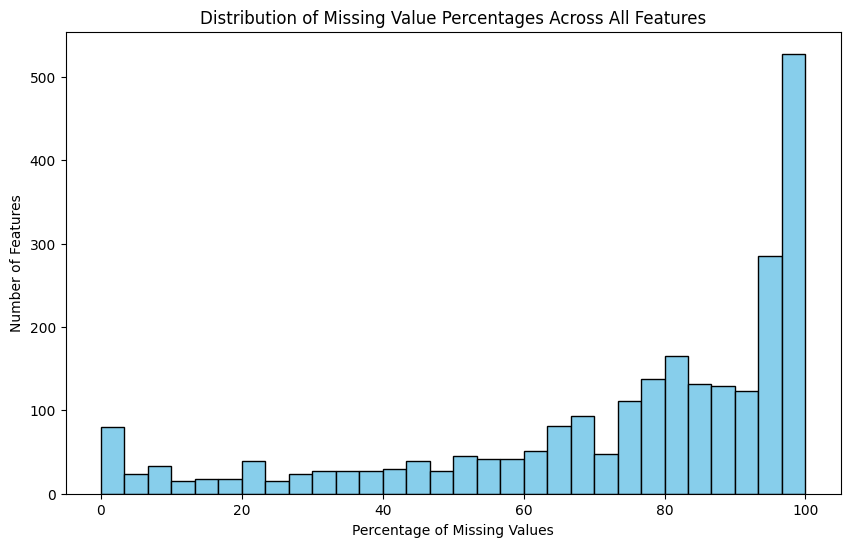

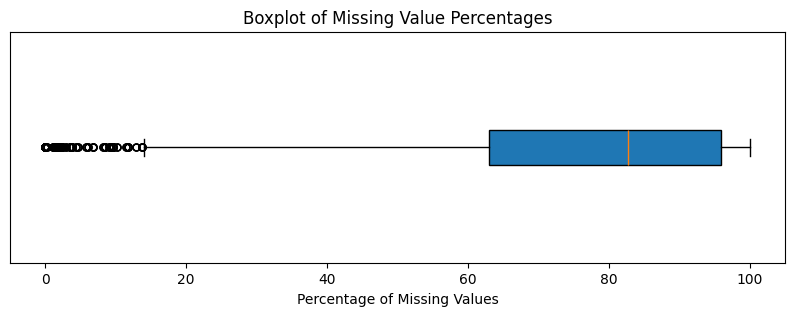

In [24]:
# Missing values are okay. They indicate an industry does not exist in a county.
missing_values_distribution(X_total)

In [25]:
# Fill NAs with 0
def fill_na(dataframe):
    dataframe = dataframe.fillna(0)
    return dataframe
# X_total=fill_na(X_total)

In [26]:
def select_columns(dataframe, prefixes_to_exclude=None, name_to_exclude=None):
    # Filter columns based on exclusion prefixes
    columns_to_exclude = [col for col in dataframe.columns if any(col.startswith(prefix) for prefix in prefixes_to_exclude)]

    # Remove the specific column name if provided
    if name_to_exclude and name_to_exclude in dataframe.columns:
        columns_to_exclude.append(name_to_exclude)

    # Final columns to keep
    columns_to_keep = [col for col in dataframe.columns if col not in columns_to_exclude]

    return dataframe[columns_to_keep]


X_total = select_columns(X_total, prefixes_to_exclude=['Est', 'Pay'], name_to_exclude='Name')
###Xucen Liao, due to the high correlation between PercentUrban and Population, exclude PercentUrban
X_total = select_columns(X_total, prefixes_to_exclude=['Est', 'Pay'], name_to_exclude='PercentUrban')
X_total.columns

Index(['Fips', 'Population', 'Longitude', 'Latitude', 'Km2', 'UrbanDensity',
       'Emp-113110', 'Emp-113310', 'Emp-114111', 'Emp-114112',
       ...
       'Emp-311111', 'Emp-311211', 'Emp-326130', 'Emp-326150', 'Emp-326220',
       'Emp-333924', 'Emp-486910', 'Emp-313230', 'Emp-335210', 'Emp-483112'],
      dtype='object', length=822)

In [27]:
X_total.head()

,Fips,Population,Longitude,Latitude,Km2,UrbanDensity,Emp-113110,Emp-113310,Emp-114111,Emp-114112,...,Emp-311111,Emp-311211,Emp-326130,Emp-326150,Emp-326220,Emp-333924,Emp-486910,Emp-313230,Emp-335210,Emp-483112
0,23001,110.0,-70.2,44.14,1287.41,3.54,<NA>,47.0,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,23001,107.0,-70.2,44.14,1287.45,3.36,<NA>,37.0,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,23001,107.0,-70.2,44.14,1287.45,3.27,<NA>,37.0,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,23001,108.0,-70.2,44.14,1287.45,3.21,<NA>,36.0,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,23001,108.0,-70.2,44.14,1287.40,3.32,<NA>,45.0,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


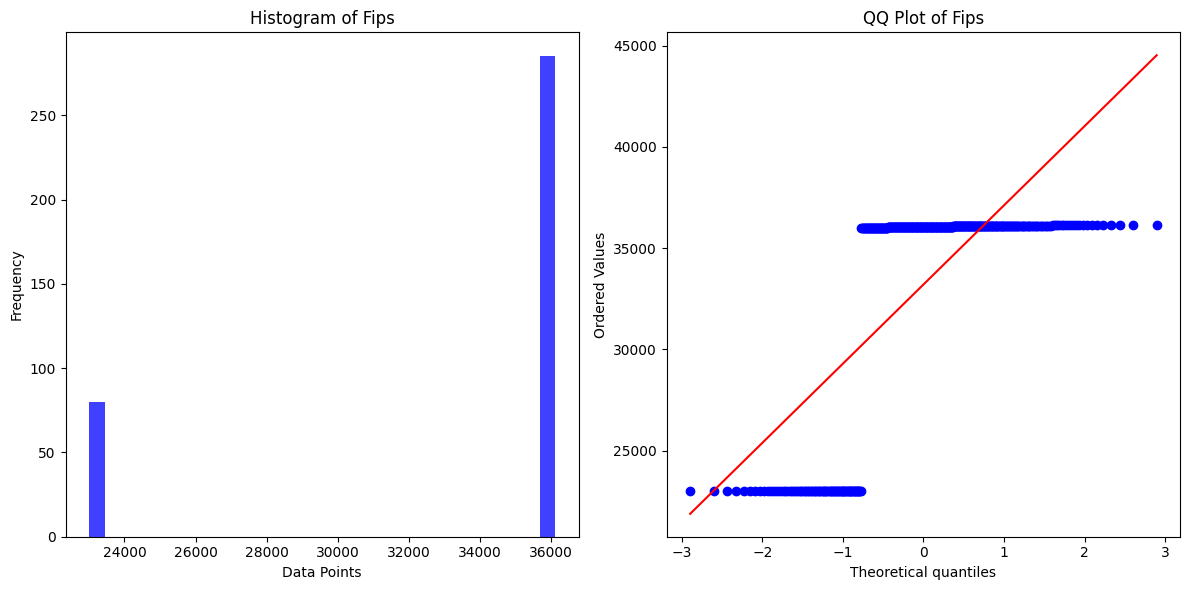

<ipython-input-28-2372694115>:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({


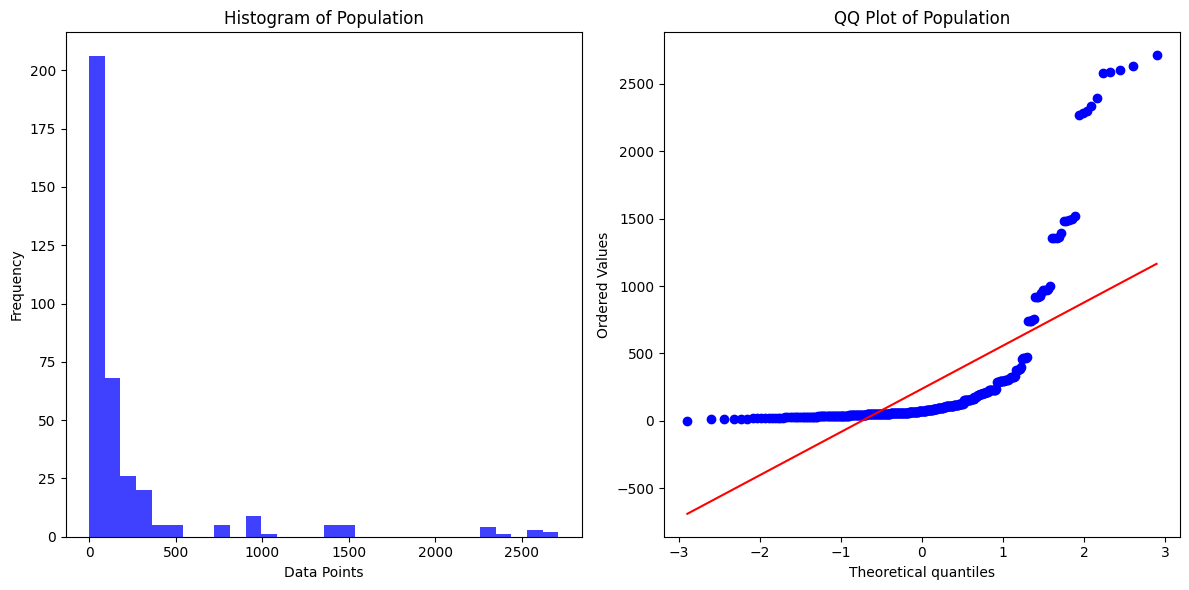

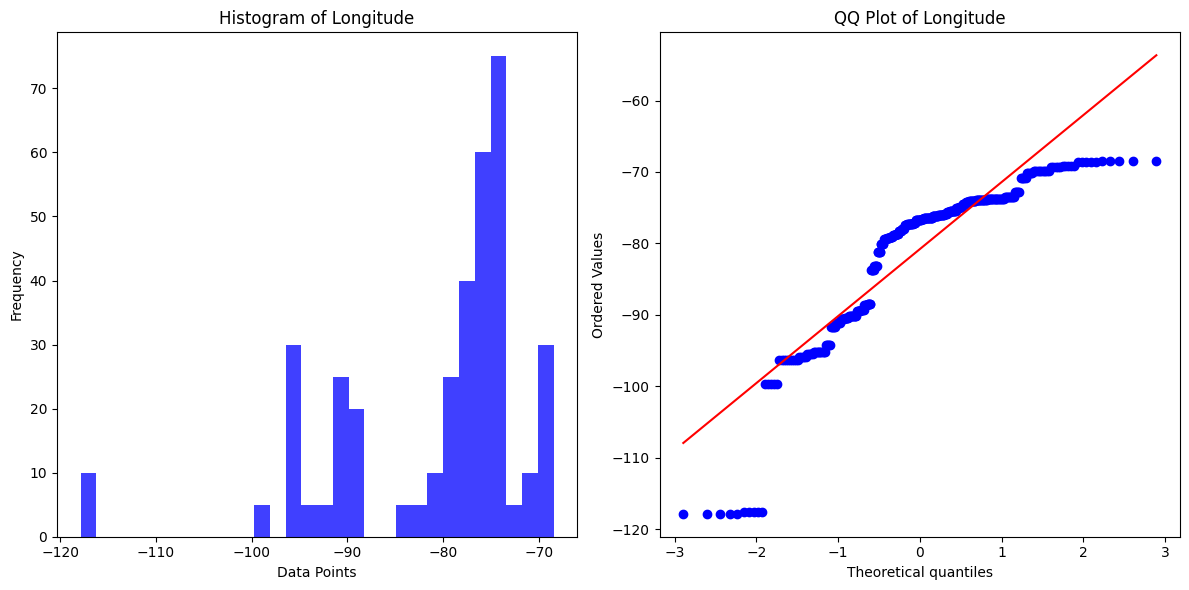

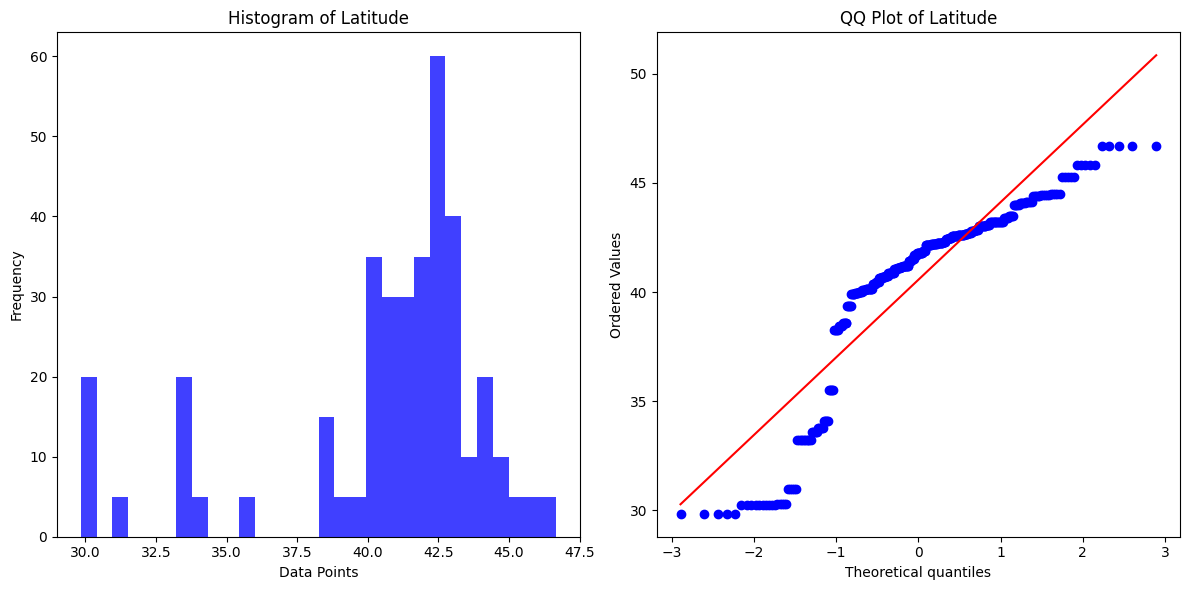

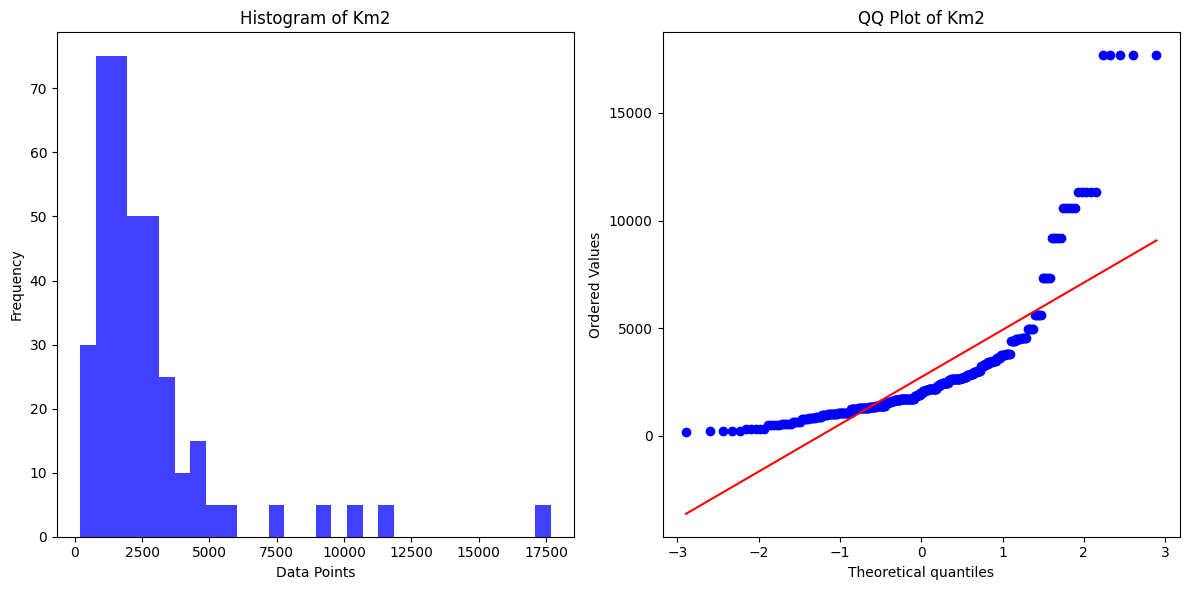

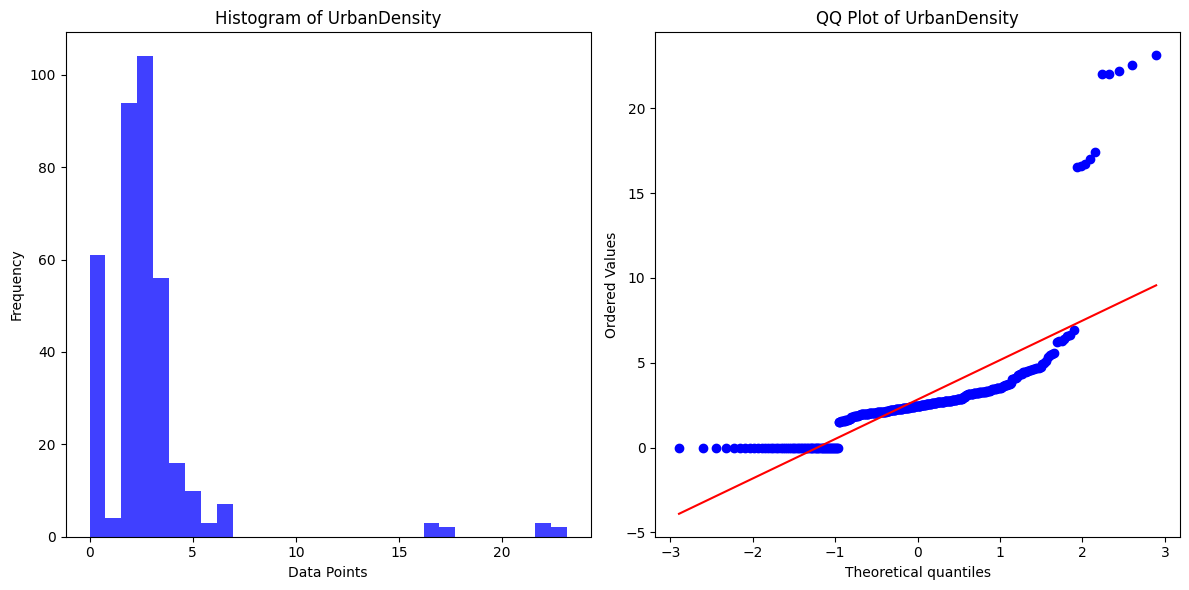

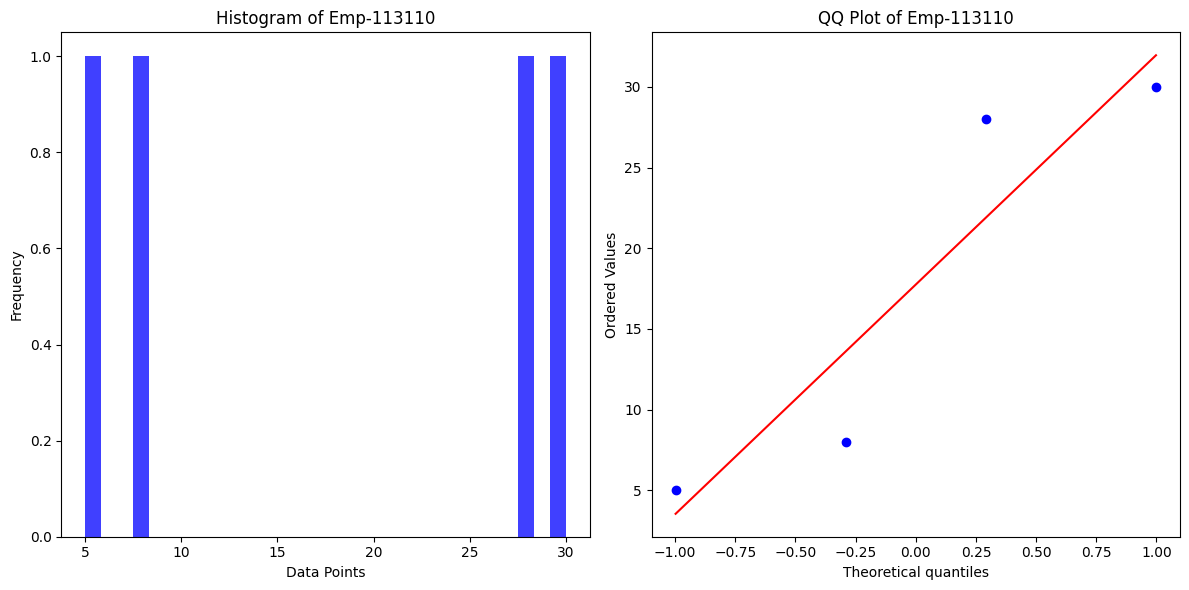

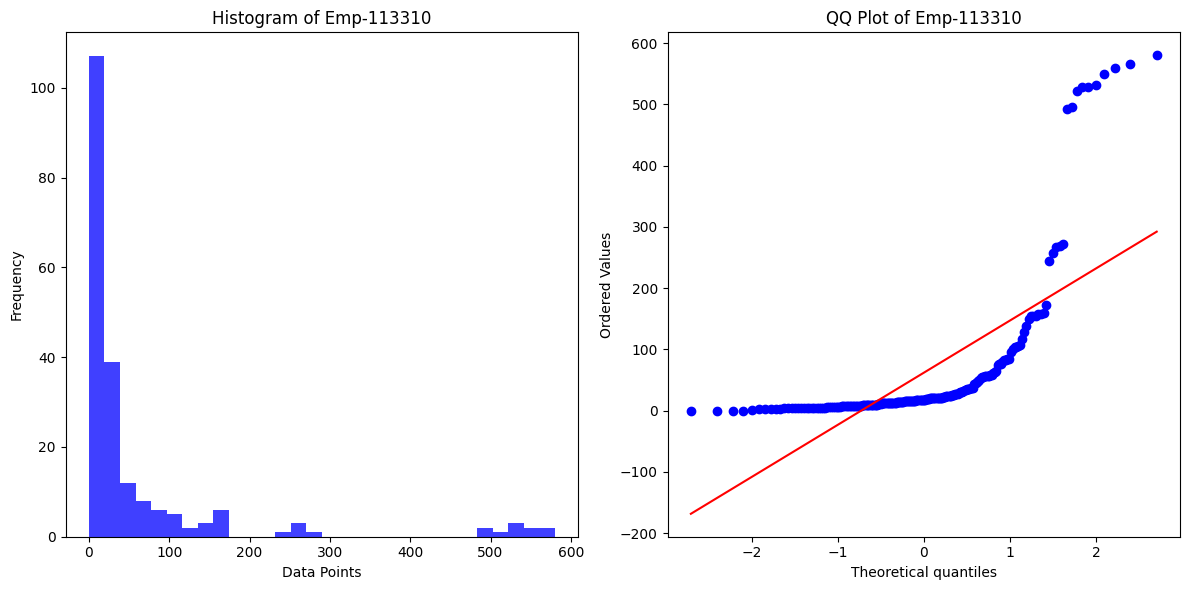

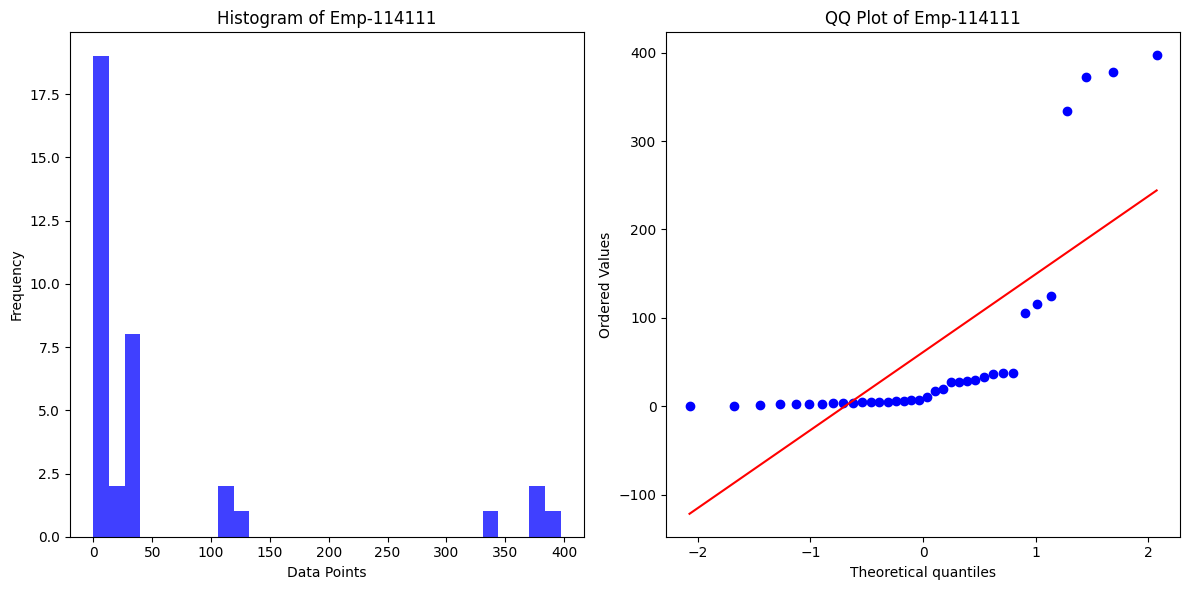

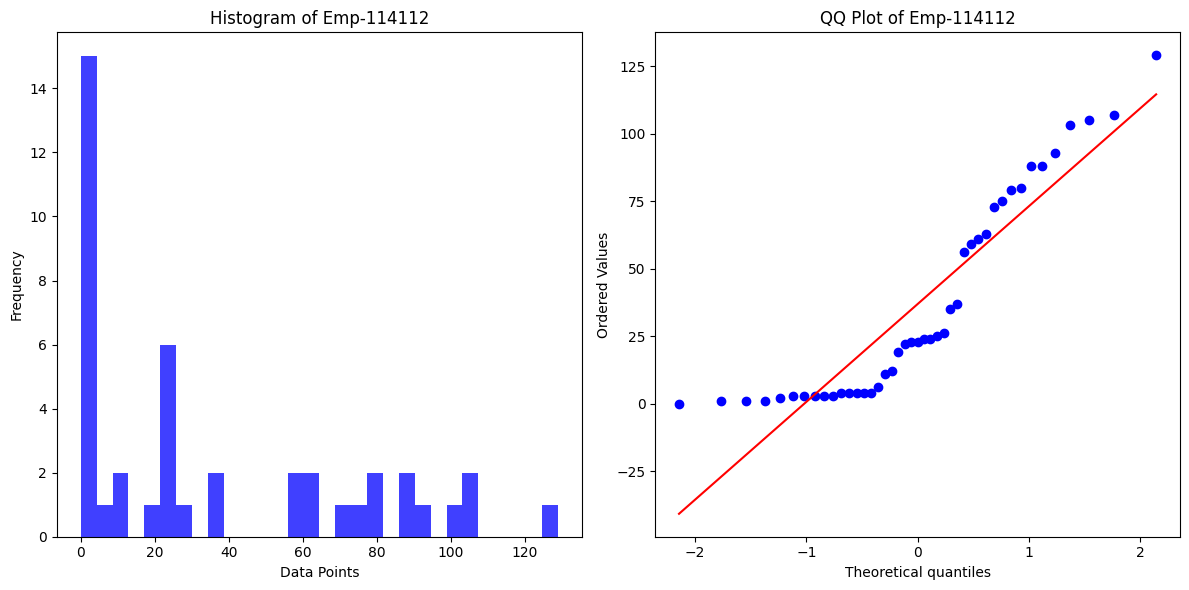

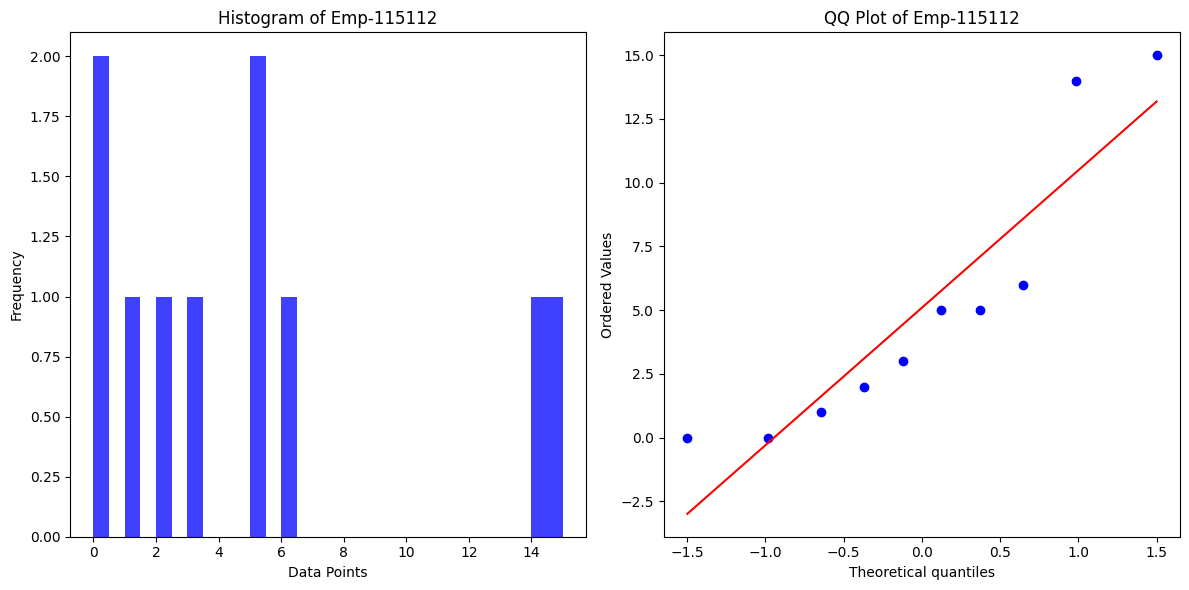

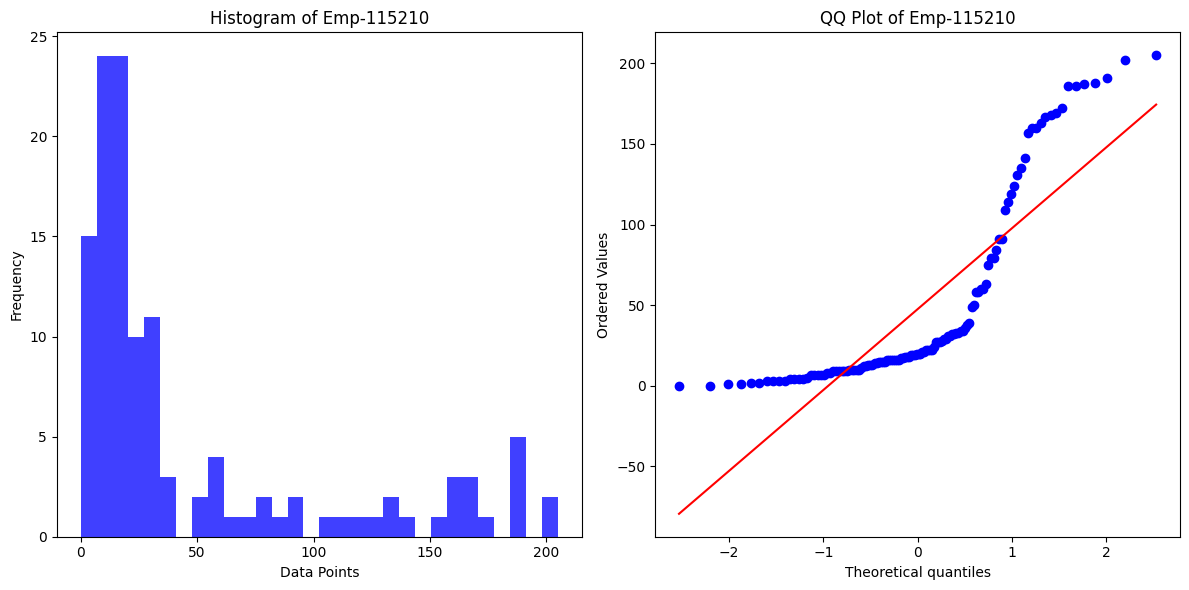

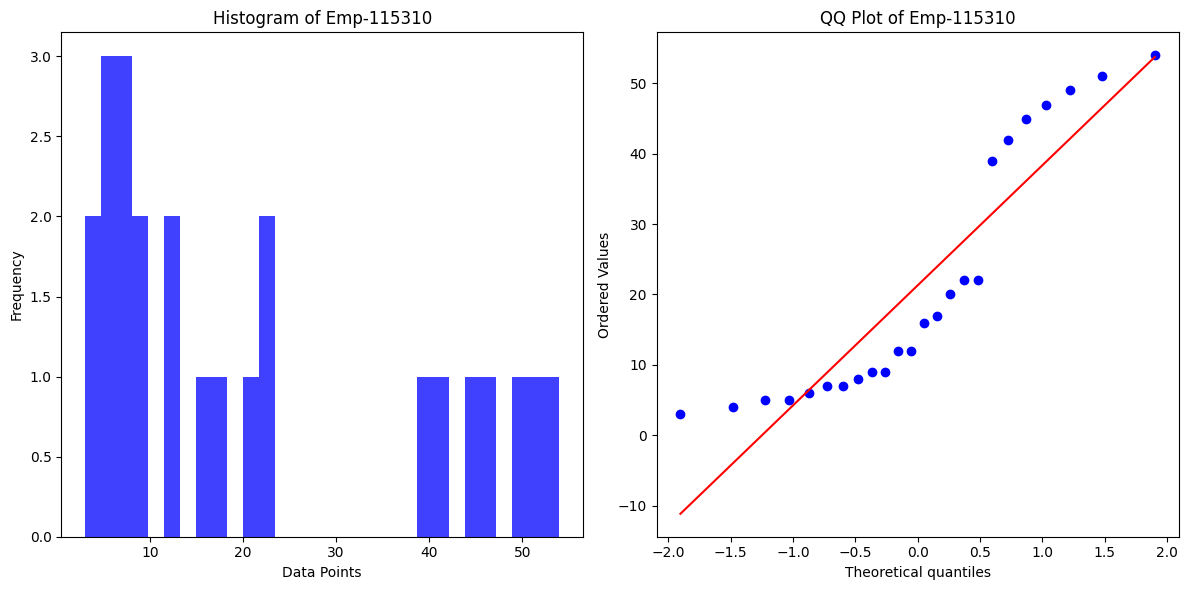

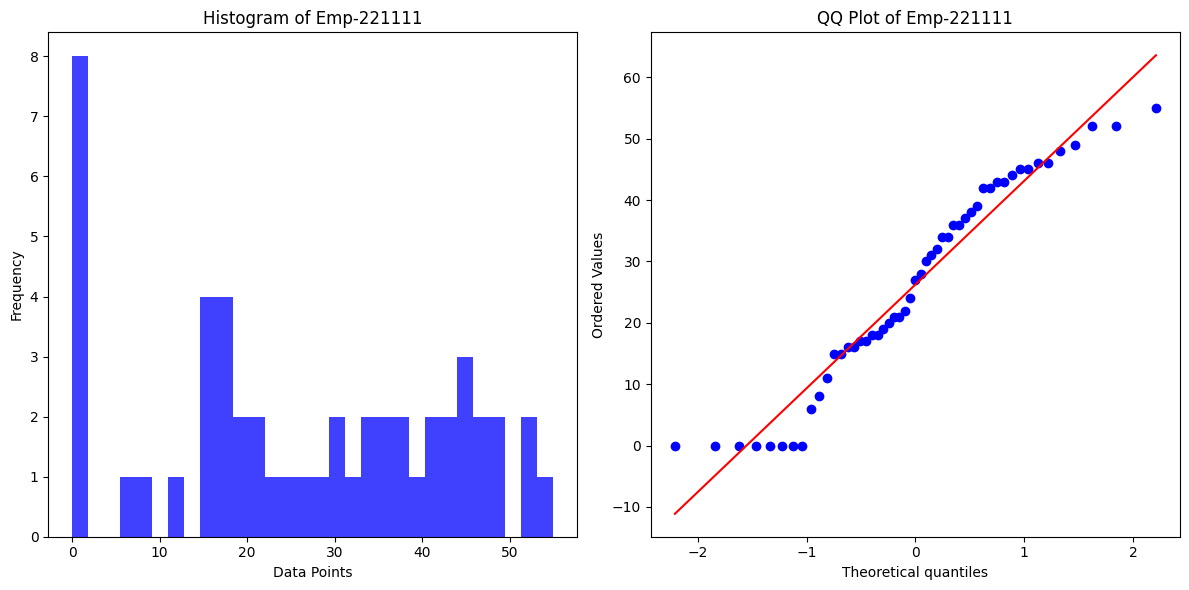

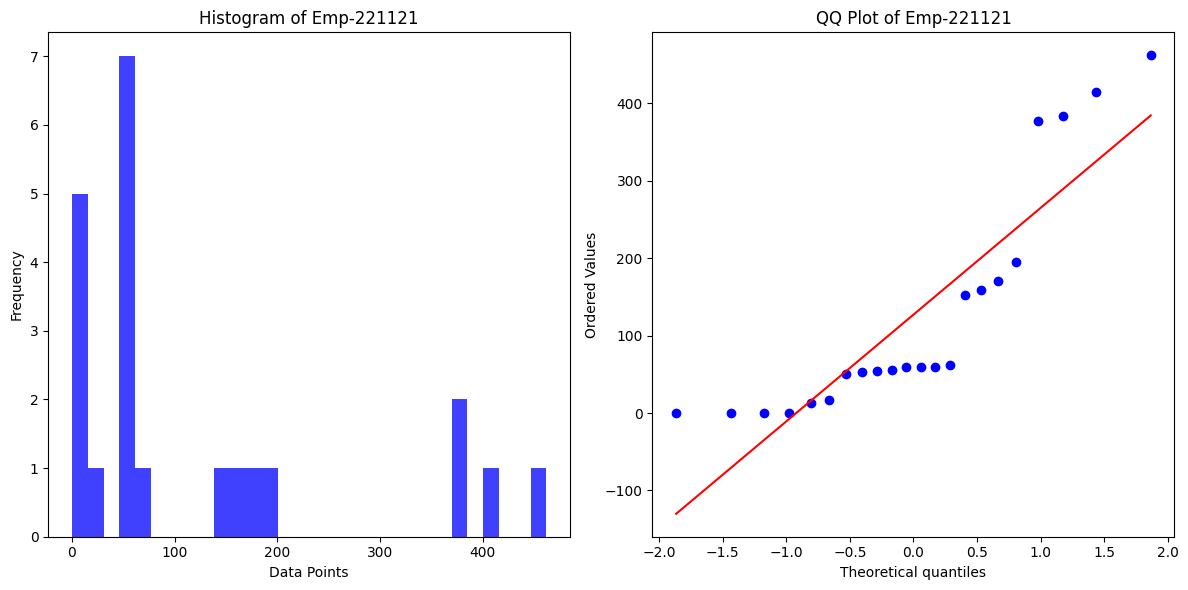

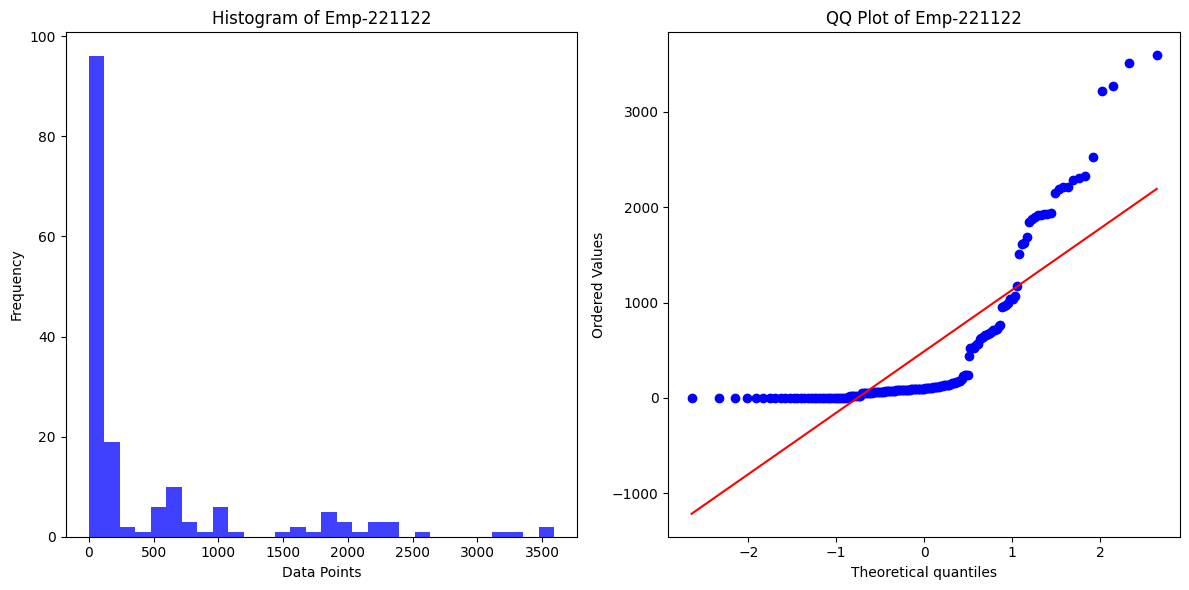

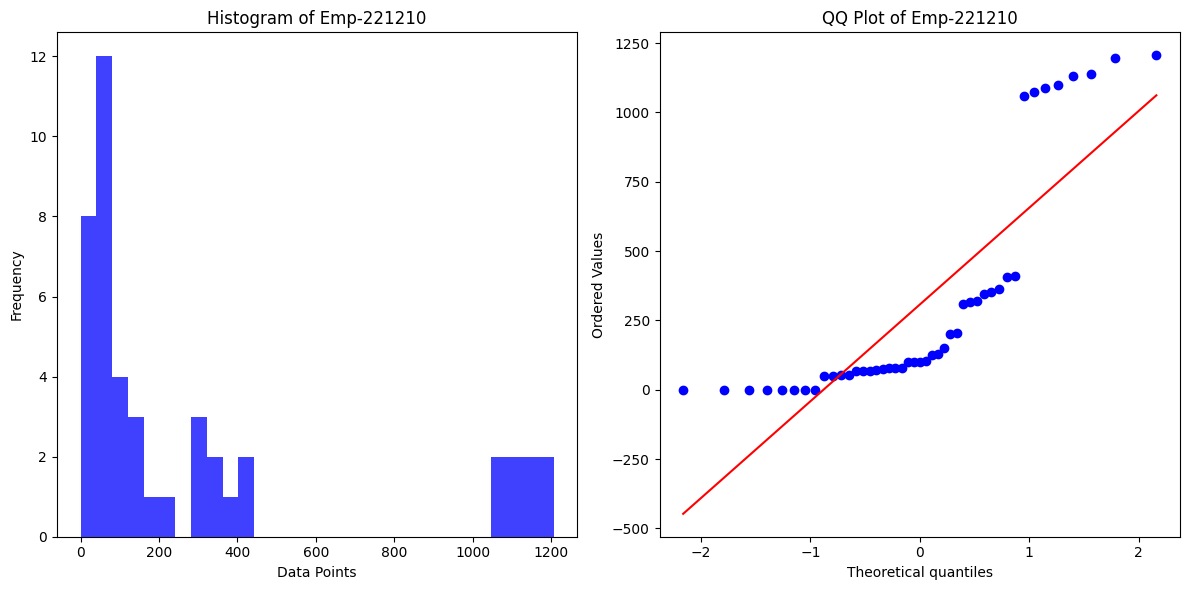

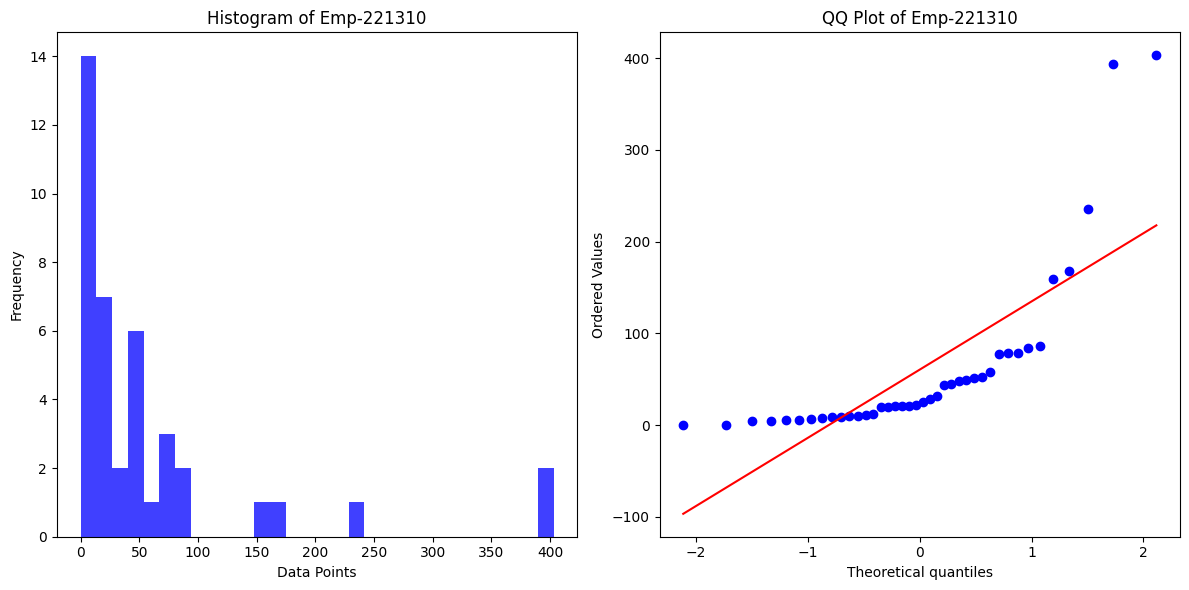

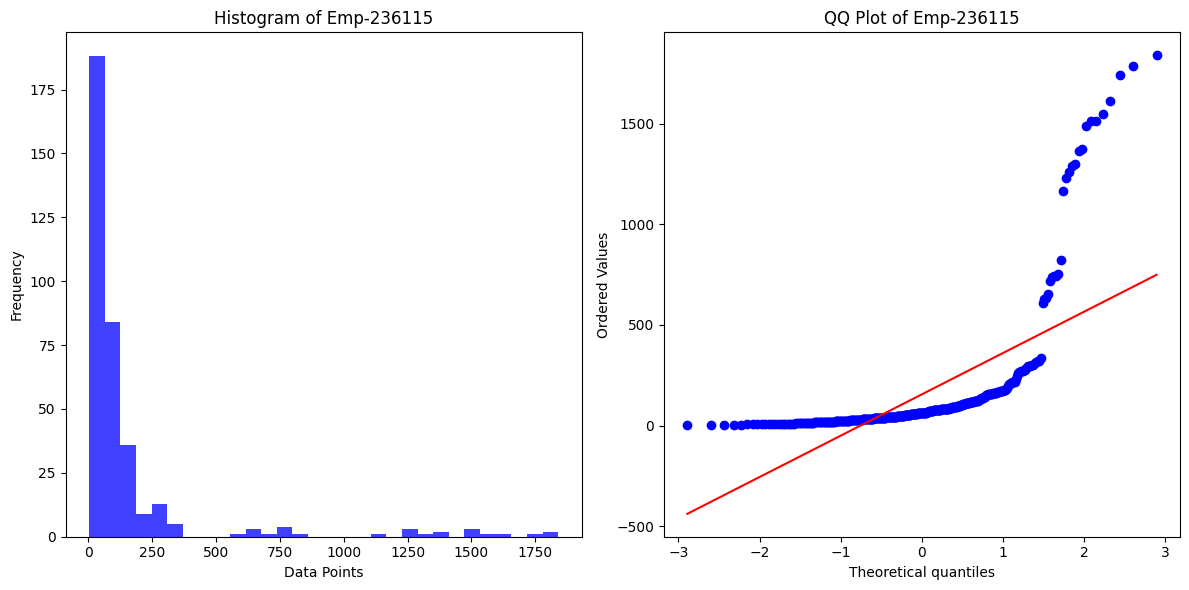

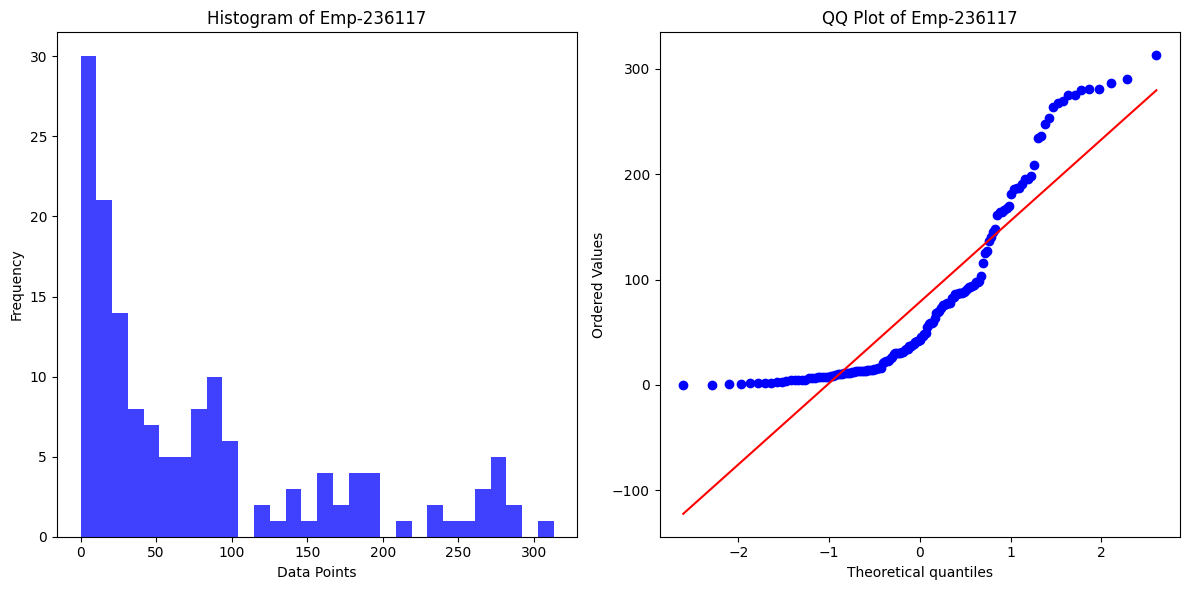

          Column  Shapiro_Statistic  Shapiro_p-value
0           Fips           0.515559     2.106758e-30
1     Population           0.466676     1.500662e-31
2      Longitude           0.828430     1.946458e-19
3       Latitude           0.817565     5.163881e-20
4            Km2           0.643445     6.799249e-27
5   UrbanDensity           0.534787     6.313813e-30
6     Emp-113110           0.820267     1.438131e-01
7     Emp-113310           0.498992     1.102689e-23
8     Emp-114111           0.549848     2.441920e-09
9     Emp-114112           0.845361     3.998924e-05
10    Emp-115112           0.831813     3.518511e-02
11    Emp-115210           0.728380     9.977856e-14
12    Emp-115310           0.829830     9.442542e-04
13    Emp-221111           0.937572     9.826156e-03
14    Emp-221121           0.775385     2.111901e-04
15    Emp-221122           0.654214     2.315099e-18
16    Emp-221210           0.701616     2.928218e-08
17    Emp-221310           0.610846     4.4124

In [28]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

def plot_histograms_and_test_normality(df, column_indices):
    results = pd.DataFrame(columns=['Column', 'Shapiro_Statistic', 'Shapiro_p-value'])

    for column in df.columns[column_indices]:
        data = df[column].dropna()

        # If cuDF, convert to pandas
        if str(type(data)).startswith("<class 'cudf"):
            data = data.to_pandas()

        # Force conversion to numeric (important)
        data = pd.to_numeric(data, errors='coerce')
        data = data.dropna()  # Final cleaning

        if len(data) < 3:
            print(f"Skipping column {column} due to insufficient valid data.")
            continue

        # Create histogram plot
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.hist(data, bins=30, alpha=0.75, color='blue')
        plt.title(f'Histogram of {column}')
        plt.xlabel('Data Points')
        plt.ylabel('Frequency')

        # Perform Shapiro-Wilk test
        shapiro_stat, shapiro_p = stats.shapiro(data)

        # QQ plot
        plt.subplot(1, 2, 2)
        stats.probplot(data, dist="norm", plot=plt)
        plt.title(f'QQ Plot of {column}')
        plt.tight_layout()
        plt.show()

        results = pd.concat([results, pd.DataFrame({
            'Column': [column],
            'Shapiro_Statistic': [shapiro_stat],
            'Shapiro_p-value': [shapiro_p]
        })], ignore_index=True)

    return results

# Example usage
column_indices = slice(0, 20)
results = plot_histograms_and_test_normality(X_total, column_indices)
print(results)


In [29]:
def apply_log_transform(df, exclude_columns=None):
    transformed_df = df.copy()
    if exclude_columns is None:
        exclude_columns = []

    for column in transformed_df.columns:
        if pd.api.types.is_numeric_dtype(transformed_df[column]) and column not in exclude_columns:
            transformed_df[column] = np.log1p(transformed_df[column])
    return transformed_df


# 'latitude', 'longitude' represent the location and we do not need to assume it is normally distributed
exclude_columns = ['Latitude', 'Longitude', 'Fips']
X_total = apply_log_transform(X_total, exclude_columns=exclude_columns)
X_total.head()


,Fips,Population,Longitude,Latitude,Km2,UrbanDensity,Emp-113110,Emp-113310,Emp-114111,Emp-114112,...,Emp-311111,Emp-311211,Emp-326130,Emp-326150,Emp-326220,Emp-333924,Emp-486910,Emp-313230,Emp-335210,Emp-483112
0,23001,4.709530,-70.2,44.14,7.161164,1.512927,<NA>,3.871201,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,23001,4.682131,-70.2,44.14,7.161195,1.472472,<NA>,3.637586,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,23001,4.682131,-70.2,44.14,7.161195,1.451614,<NA>,3.637586,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,23001,4.691348,-70.2,44.14,7.161195,1.437463,<NA>,3.610918,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,23001,4.691348,-70.2,44.14,7.161156,1.463255,<NA>,3.828641,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [30]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def preprocess_data(dataframe, scale_type='standardize', include_target=False, target=None):
    if scale_type == 'standardize':
        scaler = StandardScaler()
    elif scale_type == 'normalize':
        scaler = MinMaxScaler()
    else:
        raise ValueError("Invalid scaling type. Choose 'standardize' or 'normalize'.")

    # Convert to pandas for sklearn scalers
    if isinstance(dataframe, cudf.DataFrame):
        dataframe_pd = dataframe.to_pandas()
    else:
        dataframe_pd = dataframe

    if include_target and target in dataframe_pd.columns:
        features = dataframe_pd.drop(columns=[target])
        scaled_features = scaler.fit_transform(features)
        scaled_df = pd.DataFrame(scaled_features, columns=features.columns)
        scaled_df[target] = dataframe_pd[target].values
    else:
        scaled_features = scaler.fit_transform(dataframe_pd)
        scaled_df = pd.DataFrame(scaled_features, columns=dataframe_pd.columns)

    # Convert back to cuDF
    return cudf.DataFrame.from_pandas(scaled_df)

X_total = preprocess_data(X_total, scale_type='standardize', include_target=False)
X_total.head()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


,Fips,Population,Longitude,Latitude,Km2,UrbanDensity,Emp-113110,Emp-113310,Emp-114111,Emp-114112,...,Emp-311111,Emp-311211,Emp-326130,Emp-326150,Emp-326220,Emp-333924,Emp-486910,Emp-313230,Emp-335210,Emp-483112
0,-1.890204,0.076468,1.036214,0.916511,-0.587717,0.594563,<NA>,0.539876,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,-1.890204,0.052358,1.036214,0.916511,-0.587676,0.529124,<NA>,0.360191,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,-1.890204,0.052358,1.036214,0.916511,-0.587676,0.495384,<NA>,0.360191,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,-1.890204,0.060468,1.036214,0.916511,-0.587676,0.472493,<NA>,0.339679,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,-1.890204,0.060468,1.036214,0.916511,-0.587727,0.514215,<NA>,0.507141,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [31]:
X_total.head()

,Fips,Population,Longitude,Latitude,Km2,UrbanDensity,Emp-113110,Emp-113310,Emp-114111,Emp-114112,...,Emp-311111,Emp-311211,Emp-326130,Emp-326150,Emp-326220,Emp-333924,Emp-486910,Emp-313230,Emp-335210,Emp-483112
0,-1.890204,0.076468,1.036214,0.916511,-0.587717,0.594563,<NA>,0.539876,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,-1.890204,0.052358,1.036214,0.916511,-0.587676,0.529124,<NA>,0.360191,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,-1.890204,0.052358,1.036214,0.916511,-0.587676,0.495384,<NA>,0.360191,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,-1.890204,0.060468,1.036214,0.916511,-0.587676,0.472493,<NA>,0.339679,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,-1.890204,0.060468,1.036214,0.916511,-0.587727,0.514215,<NA>,0.507141,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


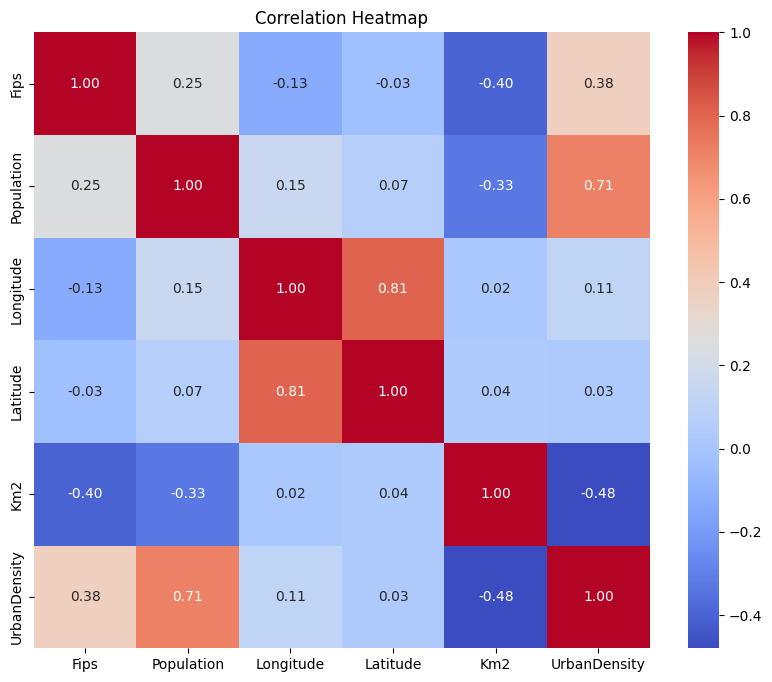

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmap(dataframe, column_prefix):
    columns_to_analyze = [col for col in dataframe.columns if not col.startswith(column_prefix)]

    # Ensure the correlation matrix is computed using pandas
    corr_matrix = dataframe[columns_to_analyze].to_pandas().corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
    plt.title('Correlation Heatmap')
    plt.show()

plot_correlation_heatmap(X_total, 'Emp')


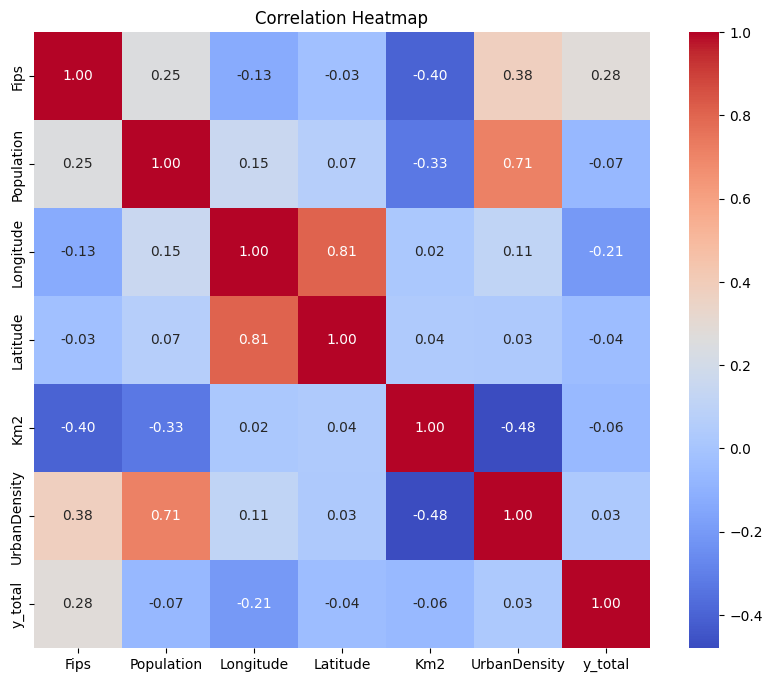

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_heatmap(dataframe, column_prefix, target_series=None, target_name='target'):
    columns_to_analyze = [col for col in dataframe.columns if not col.startswith(column_prefix)]

    if target_series is not None:
        if len(target_series) == len(dataframe):
            dataframe = dataframe.copy()
            dataframe[target_name] = target_series
            columns_to_analyze.append(target_name)
        else:
            raise ValueError("The length of target_series and dataframe must match.")

    corr_matrix = dataframe[columns_to_analyze].to_pandas().corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
    plt.title('Correlation Heatmap')
    plt.show()

plot_correlation_heatmap(X_total, 'Emp', y_total, 'y_total')


In [34]:
import matplotlib.pyplot as plt
import pandas as pd

def target_variable_analysis(df):
    if isinstance(df, cp.ndarray):
        df = pd.Series(cp.asnumpy(df))

    print("\nTarget Variable Analysis")
    print("Data Type:", df.dtype)
    print("Unique Values:", df.nunique())
    print("Value Counts:")
    print(df.value_counts())

    if df.nunique() < 20:
        df.value_counts().plot(kind='bar', color='orange', figsize=(10, 6))
        plt.title('Target Variable Distribution (Categorical)')
        plt.xlabel('Classes')
        plt.ylabel('Frequency')
        plt.show()



Target Variable Analysis
Data Type: int64
Unique Values: 2
Value Counts:
0    285
1     80
Name: count, dtype: int64


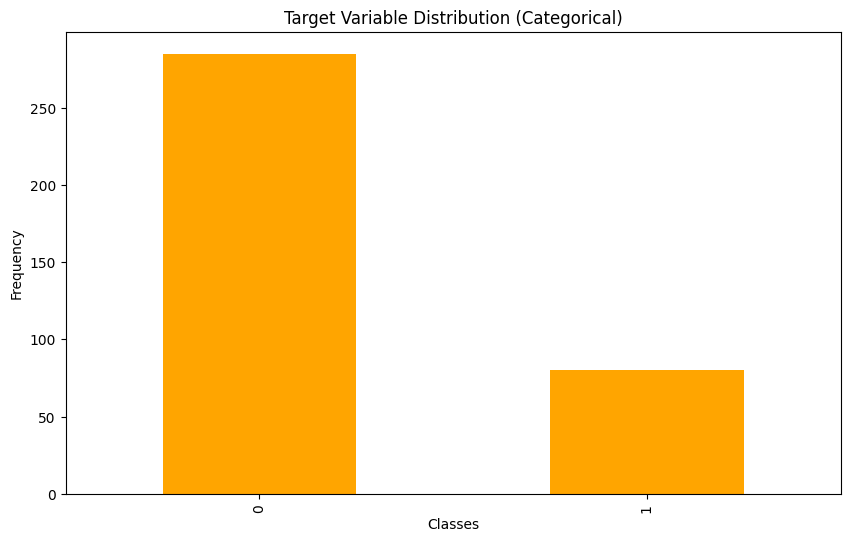

In [35]:
target_variable_analysis(y_total)

In [36]:
!pip install imbalanced-learn

In [37]:
from sklearn.model_selection import train_test_split
import os

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_total,
    y_total,
    test_size=0.2,
    random_state=42
)

# Save the train-test split datasets if required
save_training = True
if save_training:
    X_train.to_pandas().to_csv(os.path.join(full_save_dir, "X_train.csv"), index=False)
    X_test.to_pandas().to_csv(os.path.join(full_save_dir, "X_test.csv"), index=False)
    pd.Series(cp.asnumpy(y_train)).to_csv(os.path.join(full_save_dir, "y_train.csv"), index=False)
    pd.Series(cp.asnumpy(y_test)).to_csv(os.path.join(full_save_dir, "y_test.csv"), index=False)
    print("Train-test split files saved successfully.")

print("Processing completed successfully.")


Train-test split files saved successfully.
Processing completed successfully.


In [38]:
from imblearn.over_sampling import SMOTE

# Fill NaNs in X_train
X_train_filled = X_train.fillna(0)

# Convert to pandas and numpy before SMOTE
X_train_filled_pd = X_train_filled.to_pandas()
y_train_np = cp.asnumpy(y_train)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote_pd, y_train_smote_np = smote.fit_resample(X_train_filled_pd, y_train_np)

# Convert back to GPU
X_train_smote = cudf.DataFrame.from_pandas(X_train_smote_pd)
y_train_smote = cp.asarray(y_train_smote_np)

print("SMOTE applied successfully. Shapes after resampling:")
print(X_train_smote.shape, y_train_smote.shape)


SMOTE applied successfully. Shapes after resampling:
(444, 822) (444,)


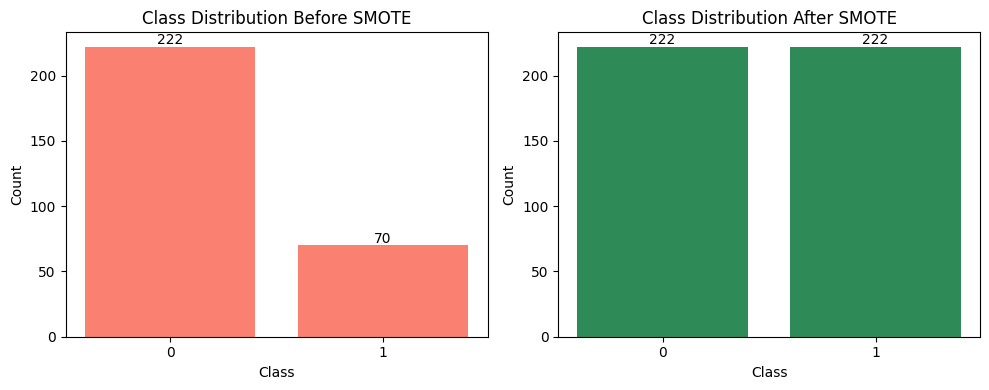

In [39]:
import matplotlib.pyplot as plt

# Count before and after SMOTE
before_counts = pd.Series(cp.asnumpy(y_train)).value_counts().sort_index()
after_counts = pd.Series(cp.asnumpy(y_train_smote)).value_counts().sort_index()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Before SMOTE
axes[0].bar(before_counts.index.astype(str), before_counts.values, color='salmon')
axes[0].set_title("Class Distribution Before SMOTE")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")
for i, v in enumerate(before_counts.values):
    axes[0].text(i, v + 2, str(v), ha='center')

# After SMOTE
axes[1].bar(after_counts.index.astype(str), after_counts.values, color='seagreen')
axes[1].set_title("Class Distribution After SMOTE")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")
for i, v in enumerate(after_counts.values):
    axes[1].text(i, v + 2, str(v), ha='center')

plt.tight_layout()
plt.show()


# Model training, testing and results saving:

Below code block can train multiple models at the same time due to use of a function and loop. This is the second version of printing results in the colab file manually using print statements and no report generator function.

In [40]:
# ------------------ Imports ------------------ #
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cupy as cp
import cudf
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.linear_model import LogisticRegression as cuLR
from cuml.svm import SVC as cuSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
import time

# ------------------ Helper Functions ------------------ #
def safe_to_cpu(arr):
    """Safely convert any GPU array (cuDF, CuPy) to CPU numpy."""
    if isinstance(arr, cp.ndarray):
        return cp.asnumpy(arr)
    elif isinstance(arr, (cudf.Series, cudf.DataFrame)):
        return arr.to_numpy()
    else:
        return arr

# ------------------ Training Function (Before SMOTE) ------------------ #
def train_multiple_models(X_train, y_train, X_test, y_test, model_types, random_state=None, n_iter=20):
    # Ensure types are GPU-ready
    if isinstance(X_train, pd.DataFrame):
        X_train = cudf.DataFrame.from_pandas(X_train)
    if isinstance(X_test, pd.DataFrame):
        X_test = cudf.DataFrame.from_pandas(X_test)
    if isinstance(y_train, (np.ndarray, pd.Series)):
        y_train = cp.asarray(y_train)
    if isinstance(y_test, (np.ndarray, pd.Series)):
        y_test = cp.asarray(y_test)

    results = []

    # Fill missing values
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    # Hyperparameters for tuning
    param_grids = {
        "xgboost": {
            "n_estimators": np.random.randint(50, 150, n_iter).tolist(),
            "learning_rate": np.random.uniform(0.01, 0.2, n_iter).tolist(),
            "max_depth": np.random.randint(3, 8, n_iter).tolist(),
            "subsample": np.random.uniform(0.6, 1.0, n_iter).tolist(),
            "colsample_bytree": np.random.uniform(0.6, 1.0, n_iter).tolist(),
        },
        "mlp": {
            "hidden_layer_sizes": [(50,), (100,), (50, 50)],
            "activation": ["relu", "tanh"],
            "solver": ["adam", "sgd"],
            "alpha": np.logspace(-4, -2, n_iter).tolist(),
            "learning_rate_init": np.random.uniform(0.0005, 0.01, n_iter).tolist(),
            "max_iter": [300, 500]
        }
    }

    for model_type in model_types:
        # Initialize models
        if model_type == "rfc":
            model = cuRF(n_estimators=100, max_depth=8, random_state=random_state, n_streams=1)
        elif model_type == "xgboost":
            model = XGBClassifier(
                tree_method="gpu_hist",
                device="cuda",
                predictor="gpu_predictor",
                use_label_encoder=False,
                eval_metric="logloss",
                random_state=random_state
            )
        elif model_type == "lr":
            model = cuLR(max_iter=1000, penalty='l2')
        elif model_type == "svm":
            model = cuSVC(probability=True, kernel="rbf", C=1.0)
        elif model_type == "mlp":
            model = MLPClassifier(random_state=random_state)
        else:
            print(f"Skipping unsupported model type: {model_type}")
            continue

        print(f"\nTraining model: {model_type.upper()}...")
        start = time.time()

        if model_type in ["xgboost", "mlp"]:
            # Only for MLP (CPU) or XGBoost search
            X_train_cpu = X_train.to_pandas()
            X_test_cpu = X_test.to_pandas()
            y_train_cpu = cp.asnumpy(y_train)

            rand_search = RandomizedSearchCV(
                model,
                param_distributions=param_grids[model_type],
                n_iter=n_iter,
                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state),
                scoring="accuracy",
                n_jobs=-1,
                verbose=1,
                random_state=random_state
            )
            rand_search.fit(X_train_cpu, y_train_cpu)
            best_model = rand_search.best_estimator_

            y_pred = best_model.predict(X_test_cpu)
            y_pred_prob = best_model.predict_proba(X_test_cpu)

        else:
            model.fit(X_train, y_train)
            best_model = model
            y_pred = model.predict(X_test)
            if hasattr(best_model, "predict_proba"):
                y_pred_prob = model.predict_proba(X_test)
            else:
                y_pred_prob = None

        end = time.time()

        # Safe conversion to CPU numpy
        y_test_cpu = safe_to_cpu(y_test)
        y_pred_cpu = safe_to_cpu(y_pred)
        y_pred_prob_cpu = safe_to_cpu(y_pred_prob) if y_pred_prob is not None else None

        # Metrics
        report = classification_report(y_test_cpu, y_pred_cpu, output_dict=True)
        accuracy_num = accuracy_score(y_test_cpu, y_pred_cpu)
        roc_auc = roc_auc_score(y_test_cpu, y_pred_prob_cpu[:, 1]) if y_pred_prob_cpu is not None else 0.0
        gmean_num = (report["0"]["recall"] * report["1"]["recall"])**0.5 if "0" in report and "1" in report else 0.0

        precision = report["1"]["precision"] if "1" in report else 0.0
        recall = report["1"]["recall"] if "1" in report else 0.0
        f1 = report["1"]["f1-score"] if "1" in report else 0.0

        results.append({
            "model_type": model_type,
            "best_model": best_model,
            "accuracy": round(accuracy_num, 4),
            "roc_auc": round(roc_auc, 4),
            "gmean": round(gmean_num, 4),
            "precision": round(precision, 4),
            "recall": round(recall, 4),
            "f1_score": round(f1, 4),
            "time": round(end - start, 2),
            "classification_report": report,
        })

        print(f"Accuracy: {accuracy_num:.4f}, ROC-AUC: {roc_auc:.4f}, F1: {f1:.4f}, G-Mean: {gmean_num:.4f}")
        print(f"Training Time: {end - start:.2f} seconds")

    return results


In [41]:
# Usage example:
# TO DO: Change RandomForest to rfc, and add rbf for Random Bits Forest
# Loop through models from the param and train the models
model_types = param['models']
#model_types = ['rfc', 'xgboost', 'lr', 'mlp','svm']

# Call the training function
results_no_smote = train_multiple_models(
    X_train,
    y_train,
    X_test,
    y_test,
    model_types,
    random_state=42
)


Training model: XGBOOST...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:12:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:12:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9863, ROC-AUC: 0.9937, F1: 0.9474, G-Mean: 0.9487
Training Time: 74.31 seconds


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:12:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:12:43] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [42]:
import pandas as pd

# Convert results into a DataFrame
results_no_smote_df = pd.DataFrame([{
    "Model": r["model_type"],
    "Accuracy": r["accuracy"],
    "ROC_AUC": r["roc_auc"],
    "F1_Score": r["f1_score"],
    "Precision": r["precision"],
    "Recall": r["recall"],
    "GMean": r["gmean"],
    "Training_Time_Seconds": r["time"]
} for r in results_no_smote])

# Save as CSV (CPU-side)
results_no_smote_df.to_csv(os.path.join(REPORT_FOLDER, "model_performance_report_no_smote.csv"), index=False)

print(" Model performance report saved to model_performance_report_no_smote.csv")
print(results_no_smote_df)


 Model performance report saved to model_performance_report_no_smote.csv
     Model  Accuracy  ROC_AUC  F1_Score  Precision  Recall   GMean  \
0  xgboost    0.9863   0.9937    0.9474        1.0     0.9  0.9487   

   Training_Time_Seconds  
0                  74.31  


In [43]:
# ------------------ Imports ------------------ #
import os
import pandas as pd
import numpy as np
import cudf
import cupy as cp
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.linear_model import LogisticRegression as cuLR
from cuml.svm import SVC as cuSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from xgboost import XGBClassifier
import time

# ------------------ Helper Functions ------------------ #
def safe_to_cpu(arr):
    if isinstance(arr, cp.ndarray):
        return cp.asnumpy(arr)
    elif isinstance(arr, (cudf.Series, cudf.DataFrame)):
        return arr.to_numpy()
    else:
        return arr

# ------------------ Training Function ------------------ #
def train_multiple_models(X_train, y_train, X_test, y_test, model_types, random_state=None, n_iter=20):
    if isinstance(X_train, pd.DataFrame):
        X_train = cudf.DataFrame.from_pandas(X_train)
    if isinstance(X_test, pd.DataFrame):
        X_test = cudf.DataFrame.from_pandas(X_test)
    if isinstance(y_train, (np.ndarray, pd.Series)):
        y_train = cp.asarray(y_train)
    if isinstance(y_test, (np.ndarray, pd.Series)):
        y_test = cp.asarray(y_test)

    results = []
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    param_grids = {
        "xgboost": {
            "n_estimators": np.random.randint(20, 50, n_iter).tolist(),
            "learning_rate": np.random.uniform(0.01, 0.1, n_iter).tolist(),
            "max_depth": np.random.randint(2, 4, n_iter).tolist(),
            "min_child_weight": np.random.randint(5, 10, n_iter).tolist(),
            "subsample": np.random.uniform(0.5, 0.7, n_iter).tolist(),
            "colsample_bytree": np.random.uniform(0.5, 0.7, n_iter).tolist(),
            "gamma": np.random.uniform(0.1, 0.5, n_iter).tolist(),
            "reg_alpha": np.random.uniform(0.5, 1.5, n_iter).tolist(),
            "reg_lambda": np.random.uniform(1.0, 3.0, n_iter).tolist(),
        },
        "mlp": {
            "hidden_layer_sizes": [(50,), (100,), (50, 50)],
            "activation": ["relu", "tanh"],
            "solver": ["adam", "sgd"],
            "alpha": np.logspace(-4, -1, n_iter).tolist(),
            "learning_rate_init": np.random.uniform(0.0001, 0.01, n_iter).tolist(),
            "max_iter": [300, 500]
        }
    }

    for model_type in model_types:
        if model_type == "rfc":
            model = cuRF(
                n_estimators=100,
                max_depth=7,
                max_features=0.7,
                random_state=random_state,
                n_streams=1
            )
        elif model_type == "xgboost":
            model = XGBClassifier(
                tree_method="gpu_hist",
                predictor="gpu_predictor",
                use_label_encoder=False,
                eval_metric="logloss",
                random_state=random_state
            )
        elif model_type == "lr":
            model = cuLR(max_iter=1000)
        elif model_type == "svm":
            model = cuSVC(probability=True, kernel='rbf', C=10.0, gamma='auto')
        elif model_type == "mlp":
            model = MLPClassifier(random_state=random_state)
        else:
            print(f"Skipping unsupported model type: {model_type}")
            continue

        print(f"\nTraining model: {model_type.upper()}...")
        start = time.time()

        if model_type in ["xgboost", "mlp"]:
            X_train_pd = X_train.to_pandas()
            X_test_pd = X_test.to_pandas()
            y_train_np = cp.asnumpy(y_train)

            rand_search = RandomizedSearchCV(
                model,
                param_distributions=param_grids[model_type],
                n_iter=n_iter,
                cv=3,
                scoring="accuracy",
                n_jobs=-1,
                verbose=1,
                random_state=random_state
            )
            rand_search.fit(X_train_pd, y_train_np)
            best_model = rand_search.best_estimator_

            y_pred = best_model.predict(X_test_pd)
            y_pred_prob = best_model.predict_proba(X_test_pd)
        else:
            model.fit(X_train, y_train)
            best_model = model
            y_pred = model.predict(X_test)
            y_pred_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

        end = time.time()

        y_test_cpu = safe_to_cpu(y_test)
        y_pred_cpu = safe_to_cpu(y_pred)
        y_pred_prob_cpu = safe_to_cpu(y_pred_prob) if y_pred_prob is not None else None

        report = classification_report(y_test_cpu, y_pred_cpu, output_dict=True, zero_division=0)
        accuracy_num = accuracy_score(y_test_cpu, y_pred_cpu)
        roc_auc = roc_auc_score(y_test_cpu, y_pred_prob_cpu[:, 1]) if y_pred_prob_cpu is not None else 0.0
        gmeans_num = (report["0"]["recall"] * report["1"]["recall"]) ** 0.5 if "0" in report and "1" in report else 0.0

        precision = report["1"]["precision"] if "1" in report else 0.0
        recall = report["1"]["recall"] if "1" in report else 0.0
        f1 = report["1"]["f1-score"] if "1" in report else 0.0

        results.append({
            "model_type": model_type,
            "best_model": best_model,
            "accuracy": round(accuracy_num, 4),
            "roc_auc": round(roc_auc, 4),
            "gmean": round(gmeans_num, 4),
            "precision": round(precision, 4),
            "recall": round(recall, 4),
            "f1_score": round(f1, 4),
            "time": round(end - start, 2),
            "classification_report": report,
        })

        print(f"Accuracy: {accuracy_num:.4f}, ROC-AUC: {roc_auc:.4f}, F1-Score: {f1:.4f}")

    return results

# ------------------ Main Execution ------------------ #

# Step 1: Split CPU Data
X_train_pd, X_val_pd, y_train_np, y_val_np = train_test_split(
    X_total_cpu.fillna(0),
    y_total_cpu,
    test_size=0.2,
    stratify=y_total_cpu,
    random_state=42
)

# Step 2: Keep only numeric columns
X_train_pd = X_train_pd.select_dtypes(include=[np.number])
X_val_pd = X_val_pd.select_dtypes(include=[np.number])

# Step 3: Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote_pd, y_train_smote_np = smote.fit_resample(X_train_pd, y_train_np)

# Step 4: Convert to GPU
X_train_smote = cudf.DataFrame.from_pandas(X_train_smote_pd)
y_train_smote = cp.asarray(y_train_smote_np)
X_val = cudf.DataFrame.from_pandas(X_val_pd)
y_val = cp.asarray(y_val_np)

print(f"After SMOTE: X_train_smote {X_train_smote.shape}, X_val {X_val.shape}")

# Step 5: Train Models
results_smote = train_multiple_models(
    X_train=X_train_smote,
    y_train=y_train_smote,
    X_test=X_val,
    y_test=y_val,
    model_types=['rfc', 'xgboost', 'lr', 'mlp', 'svm'],
    random_state=42
)

# Step 6: Save report
results_smote_df = pd.DataFrame([{
    "Model": r["model_type"],
    "Accuracy": r["accuracy"],
    "ROC_AUC": r["roc_auc"],
    "F1_Score": r["f1_score"],
    "Precision": r["precision"],
    "Recall": r["recall"],
    "GMean": r["gmean"],
    "Training_Time_Seconds": r["time"]
} for r in results_smote])

results_smote_df.to_csv(os.path.join(REPORT_FOLDER, "model_performance_report_smote.csv"), index=False)
print("Report saved to model_performance_report_smote.csv")


After SMOTE: X_train_smote (456, 2454), X_val (73, 2454)

Training model: RFC...
Accuracy: 0.9726, ROC-AUC: 0.9989, F1-Score: 0.9375

Training model: XGBOOST...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:14:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:14:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:14:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9726, ROC-AUC: 0.9978, F1-Score: 0.9375

Training model: LR...
Accuracy: 0.9452, ROC-AUC: 0.9419, F1-Score: 0.8750

Training model: MLP...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Accuracy: 0.9452, ROC-AUC: 1.0000, F1-Score: 0.8571

Training model: SVM...
Accuracy: 0.7808, ROC-AUC: 0.5000, F1-Score: 0.0000
Report saved to model_performance_report_smote.csv


# Extracting Feature Importance

Below code extracts feature importance from trained models (RandomForest, XGBoost), sorts the values, and stores them in a dictionary for further analysis.

Extracting feature importance for XGBoost...
Saved: feature_importance_xgboost.csv


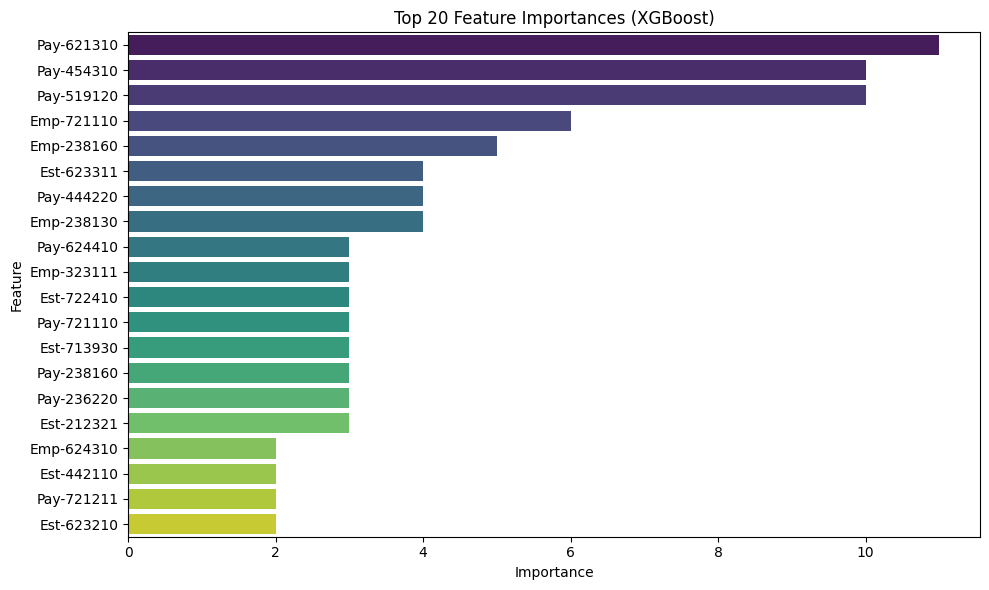

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cupy as cp
import cudf

# Helper function to safely move data to CPU
def safe_to_cpu(arr):
    if isinstance(arr, cp.ndarray):
        return cp.asnumpy(arr)
    elif isinstance(arr, (cudf.Series, cudf.DataFrame)):
        return arr.to_pandas()
    else:
        return arr

# Get feature names (ensure it's from the same source as training)
feature_names = safe_to_cpu(X_train_smote).columns.tolist()

# Loop through trained models and extract importance for XGBoost
for result in results_smote:
    model_type = result["model_type"]
    model = result["best_model"]

    if model_type == "xgboost":
        print("Extracting feature importance for XGBoost...")

        # Get importance scores from booster
        booster = model.get_booster()
        importance_dict = booster.get_score(importance_type="weight")

        # Map importance to all features (0 if not present)
        importance_values = np.array([importance_dict.get(f, 0) for f in feature_names])

        # Create DataFrame
        feature_importance_df = pd.DataFrame({
            "Feature": feature_names,
            "Importance": importance_values
        }).sort_values(by="Importance", ascending=False)

        # Save to CSV
        feature_importance_df.to_csv(os.path.join(REPORT_FOLDER, "feature_importance_xgboost.csv"), index=False)
        print("Saved: feature_importance_xgboost.csv")

        # Optional: Plot top 20 features (future-proofed)
        plt.figure(figsize=(10, 6))
        sns.barplot(
            data=feature_importance_df.head(20),
            x="Importance",
            y="Feature",
            hue="Feature",         # explicitly assign hue
            dodge=False,           # avoid bar separation
            legend=False,          # no redundant legend
            palette="viridis"
        )
        plt.title("Top 20 Feature Importances (XGBoost)")
        plt.tight_layout()
        plt.show()



Extracting feature importance for XGBoost...
Saved: feature_importance_xgboost.csv


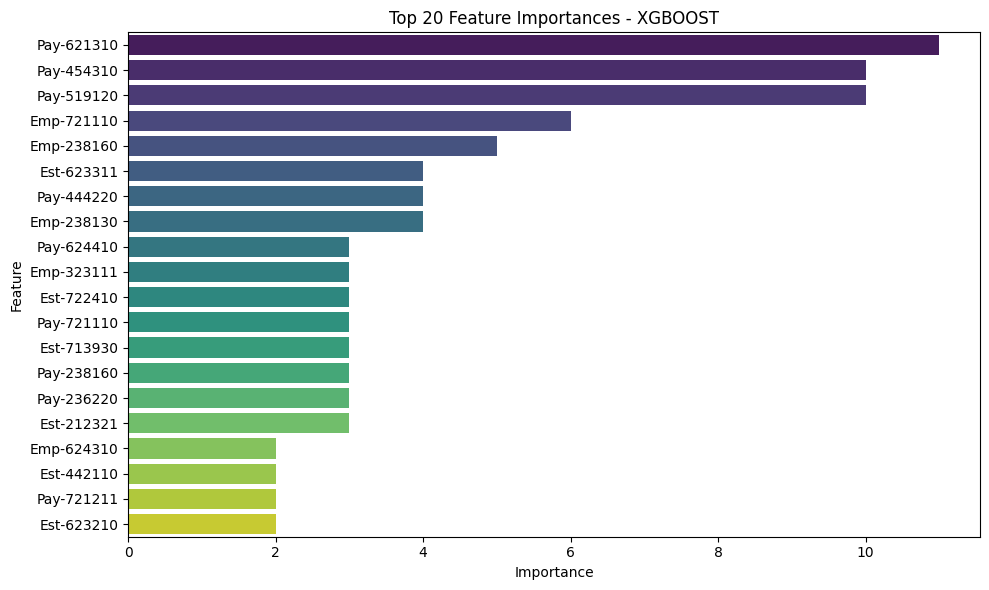

Plot saved to: /content/feature_importance/feature_importance_xgboost.png


In [45]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cupy as cp
import cudf

# ------------------ Helper Function ------------------ #
def safe_to_cpu(arr):
    """Safely move GPU data (CuPy/cuDF) to CPU (NumPy/Pandas)."""
    if isinstance(arr, cp.ndarray):
        return cp.asnumpy(arr)
    elif isinstance(arr, (cudf.Series, cudf.DataFrame)):
        return arr.to_pandas()
    else:
        return arr

# ------------------ Feature Importance Plot and Save ------------------ #
def plot_and_save_feature_importance(feature_importance_df, model_name, top_n=20, save_dir="/content/feature_importance"):
    """
    Plot and save top N feature importances as PNG.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Sort and select top N
    top_features = feature_importance_df.sort_values(by="Importance", ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=top_features,
        x="Importance",
        y="Feature",
        hue="Feature",     # needed to suppress seaborn warnings
        dodge=False,
        legend=False,
        palette="viridis"
    )
    plt.title(f"Top {top_n} Feature Importances - {model_name.upper()}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()

    # Save
    plot_path = os.path.join(save_dir, f"feature_importance_{model_name.lower()}.png")
    plt.savefig(plot_path)
    plt.show()
    print(f"Plot saved to: {plot_path}")

# ------------------ Feature Importance Extraction ------------------ #
# Get feature names from training data
feature_names = safe_to_cpu(X_train_smote).columns.tolist()

# Loop through results and process only XGBoost
for result in results_smote:
    model_type = result["model_type"]
    model = result["best_model"]

    if model_type == "xgboost":
        print("Extracting feature importance for XGBoost...")

        # Get booster importance dictionary
        booster = model.get_booster()
        importance_dict = booster.get_score(importance_type="weight")

        # Map importance to all features (0 if not present)
        importance_values = np.array([importance_dict.get(f, 0) for f in feature_names])

        # Create DataFrame
        feature_importance_df = pd.DataFrame({
            "Feature": feature_names,
            "Importance": importance_values
        })

        # Save CSV
        feature_importance_df.to_csv(os.path.join(REPORT_FOLDER, "feature_importance_xgboost.csv"), index=False)
        print("Saved: feature_importance_xgboost.csv")

        # Plot and save PNG
        plot_and_save_feature_importance(
            feature_importance_df,
            model_name="xgboost",
            top_n=20
        )


In [46]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

# Ensure output directory exists
def ensure_dir(path):
    os.makedirs(path, exist_ok=True)
    return path

# Safely move GPU data to CPU
def safe_to_cpu(arr):
    import cupy as cp
    import cudf
    if isinstance(arr, cp.ndarray):
        return cp.asnumpy(arr)
    elif isinstance(arr, (cudf.DataFrame, cudf.Series)):
        return arr.to_pandas()
    return arr

# Plot and save top N feature importances
def plot_and_save_feature_importance(df, model_name, top_n=20, save_dir=REPORT_FOLDER):
    ensure_dir(save_dir)
    df_top = df.head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_top, x="Importance", y="Feature", palette="viridis")
    plt.title(f"Top {top_n} Feature Importances ({model_name.upper()})")
    plt.tight_layout()

    plot_path = os.path.join(save_dir, f"permutation_importance_{model_name}.png")
    plt.savefig(plot_path)
    plt.show()

# Compute permutation importance
def compute_permutation_importance(model, X_val, y_val, model_name, top_n=20, save_dir=REPORT_FOLDER):
    print(f"\nComputing permutation importance for: {model_name.upper()}")

    X_val_cpu = safe_to_cpu(X_val)
    y_val_cpu = safe_to_cpu(y_val)

    # Validate feature consistency
    if hasattr(model, "feature_names_in_"):
        expected_features = model.feature_names_in_
        X_val_cpu = X_val_cpu[expected_features]

    result = permutation_importance(model, X_val_cpu, y_val_cpu, scoring="accuracy", n_repeats=10, random_state=42)

    feature_names = X_val_cpu.columns.tolist()
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": result.importances_mean
    }).sort_values(by="Importance", ascending=False)

    # Save CSV
    ensure_dir(save_dir)
    csv_path = os.path.join(save_dir, f"permutation_importance_{model_name}.csv")
    importance_df.to_csv(csv_path, index=False)
    print(f"Saved: {csv_path}")

    # Plot and save
    plot_and_save_feature_importance(importance_df, model_name=model_name, top_n=top_n, save_dir=save_dir)

# Only runs if mlp is in param['models']
cpu_safe_models = ["mlp"]  # expand this if you trained others with sklearn

for result in results_smote:
    #model_type = result["model_type"] # TODO - These might be all the models. Switch to just param['models']
    model_type = param['models']
    model = result["best_model"]

    if model_type in cpu_safe_models:
        compute_permutation_importance(
            model=model,
            X_val=X_val,  # full column set
            y_val=y_val,
            model_name=model_type,
            top_n=20
        )


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize a dictionary to store Feature Importance for different models
feature_importance_dict = {}

# Iterate through trained models
for result in results_no_smote:
    model_type = result["model_type"]
    #model = result["model"]

    # Ensure the model supports Feature Importance
    if model_type in ["RandomForest", "rbf"]:
        feature_importance = model.feature_importances_

    elif model_type == "XGBoost":
        importance_dict = model.get_booster().get_score(importance_type="weight")
        feature_importance = np.array([importance_dict.get(f, 0) for f in X_train.columns])

    elif model_type == "LogisticRegression":
        feature_importance = np.abs(model.coef_[0])

    elif model_type in ["svm", "MLP"]:
        print(f"Feature importance not directly supported for {model_type}. Consider using permutation importance or SHAP.")
        continue

    else:
        print(f"Skipping unsupported model type: {model_type}")
        continue

    # Store Feature Importance in a DataFrame
    feature_importance_df = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": feature_importance
    }).sort_values(by="Importance", ascending=False)

    # Save the Feature Importance DataFrame in the dictionary
    feature_importance_dict[model_type] = feature_importance_df

Skipping unsupported model type: xgboost


In [49]:
###Xucen Liao 04/20 - retraining Random Forest, XGboost, and LR based on top 10 important features.
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

def retrain_top_10_models(X_train, y_train, X_test, y_test, feature_importance_dict):
    models = {
        'RandomForest': RandomForestClassifier(random_state=42),
        'XGBoost': XGBClassifier(eval_metric='logloss', tree_method='hist', enable_categorical=False, random_state=42),
        'LogisticRegression': LogisticRegression(max_iter=200, solver='liblinear', random_state=42)
    }

    retrained_results = {}

    for model_name, model in models.items():
        print(f"\n--- Retraining {model_name} with Top 10 Features ---")
        # Get top 10 features
        top_features = feature_importance_dict[model_name].sort_values(by='Importance', ascending=False)['Feature'].head(10).tolist()

        # Subset data
        X_train_subset = X_train[top_features]
        X_test_subset = X_test[top_features]

        # Fit and evaluate
        model.fit(X_train_subset, y_train)
        y_pred = model.predict(X_test_subset)
        y_proba = model.predict_proba(X_test_subset)[:, 1] if hasattr(model, "predict_proba") else None

        accuracy = accuracy_score(y_test, y_pred)
        roc = roc_auc_score(y_test, y_proba) if y_proba is not None else 0.0
        report = classification_report(y_test, y_pred, output_dict=True)
        f1 = report['1']['f1-score'] if '1' in report else 0.0

        print(f"Top 10 Features: {top_features}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"ROC-AUC: {roc:.4f}")
        print(f"F1-Score: {f1:.4f}")

        retrained_results[model_name] = {
            'model': model,
            'top_features': top_features,
            'accuracy': accuracy,
            'roc_auc': roc,
            'f1_score': f1,
            'classification_report': report
        }

    return retrained_results
results_top_10 = retrain_top_10_models(X_train, y_train, X_test, y_test, feature_importance_dict)


--- Retraining RandomForest with Top 10 Features ---


KeyError: 'RandomForest'

**Plot and Save Feature Importance**

This function plots and saves the top N most important features from trained models (RandomForest, XGBoost).

**Key Steps:**
- Ensure the save directory exists (/content/feature_importance).
- Sort features by importance in descending order.
- Plot feature importance using a bar chart.
- Save the plot as a PNG file in the specified directory.
- Display the plot after saving.


In [ ]:
def plot_feature_importance(feature_importance_df, model_name, top_n=10, save_dir="/content/feature_importance"):
    """
    Plot and save the top `top_n` most important features.

    Args:
        feature_importance_df (pd.DataFrame): DataFrame containing `Feature` and `Importance` columns.
        model_name (str): Name of the model (used in the title and filename).
        top_n (int): Number of top features to display.
        save_dir (str): Directory where the figure should be saved.
    """
    # Ensure directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Sort the features by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=feature_importance_df[:top_n], palette="Blues_r", errorbar=None)

    # Set labels and title
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.title(f"Top {top_n} Feature Importances ({model_type})")

    # Save the figure to the specified directory
    file_path = os.path.join(save_dir, f"feature_importance_{model_type}.png")
    plt.savefig(file_path, bbox_inches="tight", dpi=300)
    print(f"Saved feature importance plot for {model_type} at: {file_path}")

    # Display the plot
    plt.show()


In [ ]:
# Display feature importance
# TODO(Done): get the feature importance of the parameters from the models specified in parameters.yaml file
for result in results_no_smote:
    model_type = result["model_type"]
    if model_type in feature_importance_dict:
      model = result["model"]
      plot_feature_importance(feature_importance_dict[model_type], model)

**Mapping NAICS6 Codes to Industry Names & Updating Feature Importance**

This section retrieves NAICS6 industry classifications, maps feature names (Emp-XXXXXX) to their corresponding industry names, and updates the feature importance reports accordingly.

**Key Steps:**

1. Load NAICS6 Data
   - Reads the 2017 NAICS6 codes from an Excel file.
   - Converts them into a dictionary for fast lookups.

2. Map Features to Industry Names
   - Extracts NAICS6 codes from feature names (Emp-XXXXXX).
   - Replaces them with formatted "NAICS6Code-IndustryName" strings.

3. Update Feature Importance Reports
   - Applies mapping only if the features path contains "naics".
   - Updates the feature names in feature_importance_dict.

In [ ]:
import pandas as pd

# Define the URL to the NAICS6 classification Excel file
naics6_url = "https://github.com/ModelEarth/concordance/raw/master/data-raw/6-digit_2017_Codes.xlsx"

# Read the Excel file, skipping the first row, and selecting only the relevant columns
naics6_df = pd.read_excel(naics6_url, dtype=str, skiprows=1, usecols=[0, 1])

# Rename columns for clarity
naics6_df.columns = ["NAICS6_Code", "Industry_Name"]

# Convert the DataFrame into a dictionary for quick lookups
naics6_mapping = naics6_df.set_index("NAICS6_Code")["Industry_Name"].to_dict()

# Print the first few rows to verify the cleanup
print(naics6_df.head())


In [ ]:
import re

def map_emp_to_sector(feature_name):
    """
    Replace `Emp-XXXXXX` with the corresponding NAICS6 industry name.

    Example:
        Emp-454310 -> 454310-Retail Trade
        Emp-221310 -> 221310-Water Supply and Irrigation Systems
        Latitude   -> Latitude (unchanged)

    Args:
        feature_name (str): The original feature name.

    Returns:
        str: The formatted "NAICS6Code-IndustryName" if found, otherwise the original feature name.
    """
    match = re.match(r"Emp-(\d{6})", feature_name)  # Match pattern 'Emp-XXXXXX'
    if match:
        naics_code = match.group(1)  # Extract full NAICS6 code
        industry_name = naics6_mapping.get(naics_code, "Unknown")  # Look up NAICS6 industry name
        return f"{naics_code}-{industry_name}"  # Return "NAICS6Code-IndustryName"

    return feature_name  # Return the original name if no match

# **Test cases**
print(map_emp_to_sector("Emp-454310"))  # Expected: "454310-Fuel Dealers"
print(map_emp_to_sector("Emp-221310"))  # Expected: "221310-Water Supply and Irrigation Systems"
print(map_emp_to_sector("Latitude"))    # Expected: "Latitude" (unchanged)


In [ ]:
# Ensure mapping only happens if features.path contains "naics2"
if "naics" in param["features"]["path"]:
    for model_name in feature_importance_dict:
        feature_importance_dict[model_name] = feature_importance_dict[model_name].copy()
        feature_importance_dict[model_name]["Feature"] = feature_importance_dict[model_name]["Feature"].apply(map_emp_to_sector)

# Display the first few rows of the updated feature importance for each model
for model_name, importance_df in feature_importance_dict.items():
    print(f"\nFeature Importance for {model_name}:")
    print(importance_df.head(10))

In [ ]:
feature_importance_dict

In [ ]:
# TODO - Send to repo in last step
for result in results_no_smote:
    model_type = result["model_type"]
    if model_type in feature_importance_dict:
      model = result["model"]
      plot_feature_importance(feature_importance_dict[model_type], model)

#Unified Aggregation Results & Helper Functions


Helper Functions

In [ ]:
import pandas as pd
from tabulate import tabulate
import re
import matplotlib.pyplot as plt
import pandas as pd

def get_original_column(mapped_name):
    '''
    Given a mapped feature name (e.g., "562111-Solid Waste Collection"),
    extract the first six digits and prepend 'Emp-' to form the original column name.
    If no six-digit code is found, return the mapped name.
    '''
    match = re.match(r"(\d{6})", mapped_name)
    if match:
        return f"Emp-{match.group(1)}"
    else:
        return mapped_name


def aggregate_model_results(results, feature_importance_dict=None, show_best_threshold=True):
    """
    Aggregate and display model results with optional feature importances.

    This function supports both full names (e.g. "RandomForest", "XGBoost")
    and abbreviated model types (e.g. "rfc", "xgboost", "rbf", etc.).

    Args:
        results (list): List of model result dictionaries from training runs.
        feature_importance_dict (dict): Dictionary of model_type -> feature importance DataFrames.
        show_best_threshold (bool): Whether to include best threshold in the aggregated results.

    Returns:
        dict: A unified dictionary of aggregated results.
    """
    modelResults = {}

    # Use explicit mapping for both full and abbreviated names
    for result in results:
        # Get raw model type and convert to lower-case for comparisons
        raw_model_type = result["model_type"].strip()
        model_type_lower = raw_model_type.lower()

        if model_type_lower in ["randomforest", "rfc"]:
            key = "rfc"
            model_title = "Random Forest Classifier"
        elif model_type_lower in ["xgboost"]:
            key = "xgboost"
            model_title = "XGBoost"
        elif model_type_lower in ["rbf"]:
            key = "rbf"
            model_title = "Random Bits Forest"
        elif model_type_lower in ["lr"]:
            key = "lr"
            model_title = "Logistic Regression"
        elif model_type_lower in ["svm"]:
            key = "svm"
            model_title = "Support Vector Machine"
        elif model_type_lower in ["mlp"]:
            key = "mlp"
            model_title = "Multi-Layer Perceptron"
        else:
            key = model_type_lower
            model_title = raw_model_type.title()

        # Gather the metrics from the result
        accuracy = result.get("accuracy")
        roc_auc = result.get("roc_auc")
        gmean = result.get("gmean")
        classification_report = result.get("classification_report")

        runtime_seconds = result.get("runtime_seconds",None) # Tarun , to pull runtime seconds for each dict

        entry = {
            "title": model_title,
            "accuracy": accuracy,
            "roc_auc": roc_auc,
            "gmean": gmean,
            "classification_report": classification_report,
        }
        if show_best_threshold:
            entry["best_threshold"] = result.get("best_threshold")
        if feature_importance_dict and key in feature_importance_dict:
            # Get the top 10 feature importances (as list of records)
            entry["top_importances"] = feature_importance_dict[key].head(10).to_dict(orient="records")
        else:
            entry["top_importances"] = None

        modelResults[key] = entry

    # Create a summary table for the main evaluation metrics
    summary_rows = []
    for key, result in modelResults.items():
        row = {
            "Model Key": key,
            "Title": result["title"],
            "Accuracy": result["accuracy"],
            "ROC-AUC": result["roc_auc"],
            "G-Mean": result["gmean"],
            "Runtime (s)": result.get("runtime_seconds") # Tarun , to display runtime in summary table.
        }
        if show_best_threshold:
            row["Best Threshold"] = result.get("best_threshold")
        summary_rows.append(row)
    summary_df = pd.DataFrame(summary_rows)
    print("Unified Model Results Summary:")
    print(tabulate(summary_df, headers="keys", tablefmt="pipe", showindex=False))

    # For each model, display an enhanced table for the top 10 feature importances.
    # This section augments the stored top importances with correlation information and prefix labels.
    for key, result in modelResults.items():
        top_importances = result.get("top_importances")
        if top_importances:
            fi_df = pd.DataFrame(top_importances)

            # Prepare lists to store prefix, correlation values, and correlation sign.
            prefixes = []
            correlations = []
            signs = []
            for mapped_feature in fi_df["Feature"]:
                # Use your already working helper function to get the original feature name.
                original_feature = get_original_column(mapped_feature)
                if original_feature in X_train.columns:
                    prefix = original_feature.split("-")[0]  # e.g., 'Emp', 'Pay', or 'Est'
                    corr = X_train[original_feature].corr(y_train)
                    correlations.append(round(corr, 3))
                    if corr > 0:
                        signs.append("Positive")
                    elif corr < 0:
                        signs.append("Negative")
                    else:
                        signs.append("Zero")
                else:
                    prefix = "N/A"
                    correlations.append("N/A")
                    signs.append("N/A")
                prefixes.append(prefix)

            # Append the new information to the DataFrame.
            fi_df["Prefix"] = prefixes
            fi_df["Correlation"] = correlations
            fi_df["Correlation Sign"] = signs

            print(f"\nTop 10 Feature Importances for {result['title']} ({key}):")
            print(tabulate(fi_df, headers="keys", tablefmt="pipe", showindex=False))
    return modelResults
def plot_correlation_charts(modelResults, X_train, y_train):
    """
    For each model in the aggregated results (modelResults), this function plots
    a horizontal bar chart showing the Pearson correlations of the top features
    with the target. Bars are colored green for positive correlations and salmon
    for negative correlations.

    Args:
        modelResults (dict): Aggregated model results containing a key "top_importances"
                              for each model (list of dictionaries).
        X_train (pd.DataFrame): The training features.
        y_train (pd.Series): The target values corresponding to the training features.
    """
    import matplotlib.pyplot as plt
    import pandas as pd

    for model_key, result in modelResults.items():
        top_importances = result.get("top_importances")
        if top_importances:
            # Convert the stored list of top importances into a DataFrame.
            fi_df = pd.DataFrame(top_importances)

            # If the correlation info isn't present, compute and add it.
            if ("Correlation" not in fi_df.columns or
                "Prefix" not in fi_df.columns or
                "Correlation Sign" not in fi_df.columns):

                prefixes = []
                correlations = []
                signs = []
                for mapped_feature in fi_df["Feature"]:
                    # Use your helper function to get the original feature name.
                    original_feature = get_original_column(mapped_feature)
                    if original_feature in X_train.columns:
                        # Extract prefix (e.g., "Emp", "Pay", "Est")
                        prefix = original_feature.split("-")[0]
                        corr = X_train[original_feature].corr(y_train)
                        correlations.append(round(corr, 3))
                        if corr > 0:
                            signs.append("Positive")
                        elif corr < 0:
                            signs.append("Negative")
                        else:
                            signs.append("Zero")
                    else:
                        prefix = "N/A"
                        correlations.append("N/A")
                        signs.append("N/A")
                    prefixes.append(prefix)
                # Append computed columns.
                fi_df["Prefix"] = prefixes
                fi_df["Correlation"] = correlations
                fi_df["Correlation Sign"] = signs

            # Filter out rows with non-numeric correlation values.
            fi_numeric = fi_df[fi_df["Correlation"] != "N/A"].copy()
            fi_numeric["Correlation"] = pd.to_numeric(fi_numeric["Correlation"])

            # Create a label for each feature by combining its name and prefix.
            fi_numeric["Feature_Label"] = fi_numeric["Feature"] + " (" + fi_numeric["Prefix"] + ")"

            plt.figure(figsize=(10, 5))
            # Color bars: green for positive values, salmon for negatives.
            colors = fi_numeric["Correlation"].apply(lambda x: "green" if x > 0 else "salmon")
            plt.barh(fi_numeric["Feature_Label"], fi_numeric["Correlation"], color=colors)
            plt.xlabel("Pearson Correlation")
            plt.title(f"Correlation of Top Features with Target for {result['title']}")
            plt.axvline(0, color="black", linewidth=0.8)

            # Move y-axis tick labels to the right.
            ax = plt.gca()
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position("right")

            plt.tight_layout()
            plt.show()


In [ ]:
modelResults = aggregate_model_results(results_no_smote, feature_importance_dict, show_best_threshold=True)

In [ ]:
plot_correlation_charts(modelResults, X_train, y_train)

# Upload to Github

In [57]:
from datetime import datetime
# NOTE: Github tokens have been expiring monthly, even when set to never expire.
# Using 90-day instead of never expires (which was expiring monthly)
# Expires on Mon, Sep 15 2025
DEFAULT_REPO = "modelearth/reports"
DEFAULT_TOKEN = "github_pat_XYZ"

# The following chunk is an effort to run only this last step.
# Also edit these lines in prior step. Maybe move settings here.
# TO DO: Avoid saving custom folder name in left side reports.
# TO DO: Send a test file if left side reports are not there.
GITHUB_YEAR = "2025"

GITHUB_SUBFOLDER = datetime.now().strftime("run-%Y-%m-%dT%H-%M-%S")
FULL_REPORT_PATH = os.path.join(GITHUB_YEAR, GITHUB_SUBFOLDER)


def get_file_sha(remote_path, repo, token, branch='main'):
    """
    Retrieve the SHA of an existing file in the GitHub repository.
    """
    url = f'https://api.github.com/repos/{repo}/contents/{remote_path}?ref={branch}'
    headers = {
        "Authorization": f"token {token}",
        "Accept": "application/vnd.github.v3+json"
    }
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json().get('sha')
    return None

def remove_sensitive_info(obj):
    """
    Recursively process the object. For any string, obfuscate token patterns
    by inserting a zero-width space after the first underscore. This ensures
    that tokens (even in commented-out code) do not trigger GitHub's secret scanning.
    """
    if isinstance(obj, dict):
        new_obj = {}
        for key, value in obj.items():
            new_obj[key] = remove_sensitive_info(value)
        return new_obj
    elif isinstance(obj, list):
        return [remove_sensitive_info(item) for item in obj]
    elif isinstance(obj, str):
        # Pattern matches both ghp_ tokens and github_pat_ tokens.
        pattern = r"(ghp_[A-Za-z0-9]{36}|github_pat_[A-Za-z0-9_]+)"
        def obfuscate_token(match):
            token = match.group(0)
            parts = token.split('_', 1)
            if len(parts) == 2:
                # Insert a zero-width space after the first underscore.
                return parts[0] + '_\u200b' + parts[1]
            return token
        return re.sub(pattern, obfuscate_token, obj)
    else:
        return obj

def setup_report_folder(report_folder=REPORT_FOLDER):
    """
    Create the report folder if it doesn't exist and download the report.html template and save as index.html.
    Returns the number of files in the folder.
    """
    # Create the report folder if it doesn't exist
    if not os.path.exists(report_folder):
        os.makedirs(report_folder)
        print(f"Created new directory: {report_folder}")

    # Check if index.html exists, if not download it
    index_file_path = os.path.join(report_folder, "index.html")
    if not os.path.exists(index_file_path):
        template_url = "https://raw.githubusercontent.com/ModelEarth/localsite/refs/heads/main/start/template/report.html"
        try:
            response = requests.get(template_url)
            response.raise_for_status()  # Raise an exception for HTTP errors

            with open(index_file_path, "w", encoding="utf-8") as f:
                f.write(response.text)
            print(f"Downloaded index.html template to {index_file_path}")
        except Exception as e:
            print(f"Error downloading template: {e}")

    add_readme_to_report_folder(report_folder)

    # Count the number of files in the report folder
    file_count = len([f for f in os.listdir(report_folder) if os.path.isfile(os.path.join(report_folder, f))])
    print(f"Report folder contains {file_count} files")
    return file_count

def add_readme_to_report_folder(report_folder=REPORT_FOLDER):
    """
    Create a README.md file in the report folder if it doesn't exist yet.
    """
    readme_path = os.path.join(report_folder, "README.md")

    if not os.path.exists(readme_path):
        readme_content = "# Run Models Report\n\nThis folder contains generated reports from model executions."

        with open(readme_path, "w", encoding="utf-8") as f:
            f.write(readme_content)
        print(f"Created README.md in {report_folder}")

    return readme_path

def upload_reports_to_github(repo, token, branch='main', commit_message='Reports from Run Models colab'):
    """
    Upload all files from the report folder to GitHub repository.

    Args:
        repo (str): GitHub repository in the format 'username/repo'
        token (str): GitHub personal access token
        branch (str): Branch to push to (default: 'main')
        commit_message (str): Commit message (can include {report_file_count} placeholder)
    """
    # First, set up the report folder and get file count
    report_file_count = len([f for f in os.listdir(REPORT_FOLDER) if os.path.isfile(os.path.join(REPORT_FOLDER, f))])

    # Format the commit message with the file count if needed
    if "{report_file_count}" in commit_message:
        commit_message = commit_message.format(report_file_count=report_file_count)

    print(f"Preparing to push {report_file_count} reports to: {repo}")

    # GitHub API endpoint for getting the reference
    api_url = f"https://api.github.com/repos/{repo}"
    headers = {
        "Authorization": f"token {token}",
        "Accept": "application/vnd.github.v3+json"
    }

    try:
        # Get the current reference (SHA) of the branch
        ref_response = requests.get(f"{api_url}/git/refs/heads/{branch}", headers=headers)
        ref_response.raise_for_status()
        ref_sha = ref_response.json()["object"]["sha"]

        # Get the current commit to which the branch points
        commit_response = requests.get(f"{api_url}/git/commits/{ref_sha}", headers=headers)
        commit_response.raise_for_status()
        base_tree_sha = commit_response.json()["tree"]["sha"]

        # Create a new tree with all the files in the report folder
        new_tree = []

        report_path = Path(REPORT_FOLDER)
        for file_path in report_path.glob("**/*"):
            if file_path.is_file():
                # Calculate the path relative to the report folder
                relative_path = file_path.relative_to(report_path)
                #github_path = f"reports/{relative_path}"
                thefile = file_path.name
                github_path = f"{FULL_REPORT_PATH}/{thefile}"
                print(f"github_path: {github_path}")

                # Read file content and encode as base64
                with open(file_path, "rb") as f:
                    content = f.read()

                # Add the file to the new tree
                new_tree.append({
                    "path": github_path,
                    "mode": "100644",  # File mode (100644 for regular file)
                    "type": "blob",
                    "content": content.decode('utf-8', errors='replace')
                })

        # Create a new tree with the new files
        new_tree_response = requests.post(
            f"{api_url}/git/trees",
            headers=headers,
            json={
                "base_tree": base_tree_sha,
                "tree": new_tree
            }
        )
        new_tree_response.raise_for_status()
        new_tree_sha = new_tree_response.json()["sha"]

        # Create a new commit
        new_commit_response = requests.post(
            f"{api_url}/git/commits",
            headers=headers,
            json={
                "message": commit_message,
                "tree": new_tree_sha,
                "parents": [ref_sha]
            }
        )
        new_commit_response.raise_for_status()
        new_commit_sha = new_commit_response.json()["sha"]

        # Update the reference to point to the new commit
        update_ref_response = requests.patch(
            f"{api_url}/git/refs/heads/{branch}",
            headers=headers,
            json={"sha": new_commit_sha}
        )
        update_ref_response.raise_for_status()

        print(f"Pushed {report_file_count} files to GitHub repository: {repo}")
        print(f"Branch: {branch}")
        print(f"Commit message: {commit_message}")
        print(f"Repo: {DEFAULT_REPO}")
        return True

    except Exception as e:
        print(f"Error uploading files to GitHub: {e}")
        return False

upload_reports_to_github(DEFAULT_REPO, DEFAULT_TOKEN, branch='main', commit_message='Pushed report files to GitHub')

#upload_notebook_to_github("Run-Models-bkup.ipynb", DEFAULT_REPO, DEFAULT_TOKEN, branch='main', commit_message='Update notebook')

Preparing to push 6 reports to: modelearth/reports
github_path: 2025/run-2025-06-17T20-41-23/model-options.csv
github_path: 2025/run-2025-06-17T20-41-23/README.md
github_path: 2025/run-2025-06-17T20-41-23/model_performance_report_no_smote.csv
github_path: 2025/run-2025-06-17T20-41-23/feature_importance_xgboost.csv
github_path: 2025/run-2025-06-17T20-41-23/index.html
github_path: 2025/run-2025-06-17T20-41-23/model_performance_report_smote.csv
Pushed 6 files to GitHub repository: modelearth/reports
Branch: main
Commit message: Pushed report files to GitHub
Repo: modelearth/reports


True